In [ ]:
yandex = False
downloadMovieLens = False

# Requirements

In [ ]:
%%bash
nvidia-smi

Sun May 25 09:20:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:8C:00.0 Off |                    0 |
| N/A   36C    P0              25W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 48.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
%pip list

Package                   Version
------------------------- --------------
aiohappyeyeballs          2.6.1
aiohttp                   3.11.18
aiosignal                 1.3.2
anyio                     4.9.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
async-timeout             5.0.1
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.4
bleach                    6.2.0
boto3                     1.28.82
botocore                  1.31.85
certifi                   2025.4.26
cffi                      1.17.1
charset-normalizer        3.4.2
cloudpickle               3.0.0
comm                      0.2.2
contourpy                 1.3.2
cycler                    0.12.1
Cython                    3.0.11
debugpy                   1.8.5
decorator                 5.2.1
defusedxml                0.7.1
exceptiongroup            1.3.0
executing  

In [ ]:
%pip check

jupyterlab 4.2.0 requires async-lru, which is not installed.
jupyterlab 4.2.0 requires httpx, which is not installed.
jupyterlab 4.2.0 requires ipykernel, which is not installed.
jupyterlab 4.2.0 requires jupyter-core, which is not installed.
jupyterlab 4.2.0 requires jupyter-lsp, which is not installed.
jupyterlab 4.2.0 requires jupyter-server, which is not installed.
jupyterlab 4.2.0 requires jupyterlab-server, which is not installed.
jupyterlab 4.2.0 requires notebook-shim, which is not installed.
jupyterlab 4.2.0 requires tomli, which is not installed.
jupyterlab 4.2.0 requires tornado, which is not installed.
lightning 2.5.1 has requirement packaging<25.0,>=20.0, but you have packaging 25.0.
pipdeptree 2.26.1 has requirement pip>=24.2, but you have pip 23.0.1.
botocore 1.31.85 has requirement urllib3<2.1,>=1.25.4; python_version >= "3.10", but you have urllib3 2.4.0.


In [ ]:
%pip freeze > requirements.txt

# https://libraries.io/pypi/lightning/2.5.1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# **Запуск Drive и внедрение MovieLens10M**

In [ ]:
import zipfile
if yandex:
    if downloadMovieLens:
        !curl -L -o ml-10m.zip https://files.grouplens.org/datasets/movielens/ml-10m.zip
        with zipfile.ZipFile('ml-10m.zip', 'r') as zip_ref:
            zip_ref.extractall('ml-10m')
else:
    from google.colab import drive
    drive.mount("/content/drive")
    !unzip '/content/drive/MyDrive/ml-10m.zip' -d ml-10m

Mounted at /content/drive
Archive:  /content/drive/MyDrive/ml-10m.zip
   creating: ml-10m/ml-10M100K/
  inflating: ml-10m/ml-10M100K/allbut.pl  
  inflating: ml-10m/ml-10M100K/movies.dat  
  inflating: ml-10m/ml-10M100K/ratings.dat  
  inflating: ml-10m/ml-10M100K/README.html  
  inflating: ml-10m/ml-10M100K/split_ratings.sh  
  inflating: ml-10m/ml-10M100K/tags.dat  


In [ ]:
import sys
sys.modules["torchaudio"] = None

import numpy as np
import pandas as pd
import os, pickle, joblib, json, random
import matplotlib.pyplot as plt
# import torch
# from torch import Tensor
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# import torch.nn.functional as F
# from typing import Dict, Optional
from scipy.sparse import csr_matrix, hstack
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, normalize
# from tqdm import tqdm

# import lightning
# from lightning import Trainer
# import lightning.pytorch as pl
# from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
# from lightning.pytorch.loggers import WandbLogger

# import wandb
# os.environ["WANDB_API_KEY"] = "f782c28f90256590b07acb0981f2021f81563dee"
# wandb.login()
# import torchmetrics
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# print(torch.__version__,
# lightning.__version__,
# torchmetrics.__version__,
# wandb.__version__,
# pd.__version__
# )

# **MOVIES DATAFRAME**

```
movies_df = pd.read_csv(
    "/content/ml-10m/ml-10M100K/movies.dat",
    sep="::",
    engine="python",
    header=None,
    names=["movieId", "title", "genres"],
    dtype={"movieId": "uint16", "title": "string", "genres": "string"},
    encoding="latin1",
)
# movies_df = pd.read_csv('/home/jupyter/datasphere/project/ml-10m/ml-10M100K/movies.dat', sep='::', engine='python', header=None, names=['movieId', 'title', 'genres'], dtype = {'movieId': 'uint16', 'title': 'string', 'genres': 'string'}, encoding='latin1')
movies_df["genres"] = movies_df["genres"].str.split("|")
# genres_expanded = movies_df.explode("genres")
movies_df.head()
```
movieId	title	genres

0	1	Toy Story (1995)	[Adventure, Animation, Children, Comedy, Fantasy]

In [ ]:
import ast
def parse_genres(genres_str):
    try:
        return ast.literal_eval(genres_str)
    except (ValueError, SyntaxError):
        return []
if yandex:
    movie_path = '/home/jupyter/datasphere/project/movies_with_tmdb_meta.csv'
else:
    movie_path = '/content/drive/MyDrive/movies_with_tmdb_meta.csv'
movies_df = pd.read_csv(
    movie_path,
    dtype={
        "movieId": "uint32",
        "title": "string",
        "year": "Int64",
        "clean_title": "string",
        "Overview": "string",
        "Actors": "string",
        "Director": "string",
        "Rated": "string",
        "PosterURL": "string",
        "TMDB_ID": "Int64",
    },
    converters={
        "genres": parse_genres
    },
    encoding="latin1",
    quotechar='"'
)

# **MOVIES Setup**

Сбор информации о кратком описании, актерах, режиссере(director), возрастной рейтинг, URL постера и IMDb id

In [ ]:
import os
import json
import pandas as pd
import requests
from tqdm import tqdm
import re
import sys

TMDB_API_KEY = "2372f138e77fa90cea4df7ae8c36fe8c"
TMDB_CACHE_FILE = "tmdb_cache.json"

def clean_title(title):
    title = re.sub(r"\s*\(.*?\)", "", title).strip()
    match = re.match(r"^(.*),\s(The|A|An)$", title)
    if match:
        return f"{match.group(2)} {match.group(1)}"
    return title

def load_cache():
    if os.path.exists(TMDB_CACHE_FILE):
        with open(TMDB_CACHE_FILE, "r", encoding="utf-8") as f:
            return json.load(f)
    return {}

def save_cache(cache):
    with open(TMDB_CACHE_FILE, "w", encoding="utf-8") as f:
        json.dump(cache, f, ensure_ascii=False, indent=2)

def fetch_tmdb_metadata(title, year):
    params = {"api_key": TMDB_API_KEY, "query": title, "year": year}

    try:
        resp = requests.get("https://api.themoviedb.org/3/search/movie", params=params)
        resp.raise_for_status()
        results = resp.json().get("results")
        if not results:
            return {}

        movie_id = results[0]["id"]

        details_url = f"https://api.themoviedb.org/3/movie/{movie_id}"
        details = requests.get(details_url, params={"api_key": TMDB_API_KEY}).json()

        credits_url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
        credits = requests.get(credits_url, params={"api_key": TMDB_API_KEY}).json()
        actors = [cast["name"] for cast in credits.get("cast", [])[:5]]
        directors = [crew["name"] for crew in credits.get("crew", []) if crew["job"] == "Director"]

        rated = ""
        release_url = f"https://api.themoviedb.org/3/movie/{movie_id}/release_dates"
        release_data = requests.get(release_url, params={"api_key": TMDB_API_KEY}).json()
        for entry in release_data.get("results", []):
            if entry["iso_3166_1"] == "US":
                for rel in entry.get("release_dates", []):
                    if rel.get("certification"):
                        rated = rel["certification"]
                        break
                break

        poster_path = details.get("poster_path")
        poster_url = f"https://image.tmdb.org/t/p/w500{poster_path}" if poster_path else ""

        return {
            "Overview": details.get("overview", ""),
            "Actors": ", ".join(actors),
            "Director": ", ".join(directors),
            "Rated": rated,
            "PosterURL": poster_url,
            "TMDB_ID": movie_id
        }

    except requests.exceptions.RequestException:
        return {}

def fetch_tmdb_cached(title, year, cache):
    key = f"{title} ({year})"
    if key in cache:
        return cache[key]

    metadata = fetch_tmdb_metadata(title, year)
    cache[key] = metadata
    return metadata

In [ ]:
import re
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)").astype(float).fillna(0).astype(int)
movies_df["clean_title"] = movies_df["title"].str.replace(r"\s*\(\d{4}\)$", "", regex=True)

cache = load_cache()
meta = []

for row in tqdm(movies_df.itertuples(index=False), total=len(movies_df)):
    title = clean_title(row.clean_title)
    year = row.year
    metadata = fetch_tmdb_cached(title, year, cache)
    meta.append(metadata)

save_cache(cache)
meta_df = pd.DataFrame(meta)
movies_df = pd.concat([movies_df, meta_df], axis=1)
movies_df.to_csv("movies_with_tmdb_meta.csv", index=False)

100%|██████████| 10681/10681 [38:46<00:00,  4.59it/s]


### **Список жанров**

In [ ]:
movies_df = pd.read_csv(
    "/content/ml-10m/ml-10M100K/movies.dat",
    sep="::",
    engine="python",
    header=None,
    names=["movieId", "title", "genres"],
    dtype={"movieId": "uint16", "title": "string", "genres": "string"},
    encoding="latin1",
)
unique_set = set(movies_df["genres"].str.split("|").sum())
print(unique_set)
print(len(unique_set))

{'Musical', 'IMAX', 'War', 'Drama', 'Mystery', 'Children', '(no genres listed)', 'Horror', 'Adventure', 'Comedy', 'Action', 'Sci-Fi', 'Thriller', 'Animation', 'Crime', 'Documentary', 'Fantasy', 'Film-Noir', 'Western', 'Romance'}
20


### **График частоты жанров**

In [ ]:
genre_distr = movies_df["genres"].str.split("|").explode().value_counts()
genre_distr = genre_distr.sort_values(ascending=True)
plt.figure(figsize=(16, 11))
plt.grid(True, axis="x", alpha=0.7)
ax = plt.barh(genre_distr.index, genre_distr.values)
plt.xticks(fontsize=12)
plt.yticks(fontsize=20, rotation=-30, ha="right", va="bottom")
plt.title("Распределение жанров", fontsize=24)
plt.xlabel("Количество фильмов", fontsize=20)
plt.savefig("genre_distr.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# **RATINGS DATAFRAME**

In [ ]:
if yandex:
    ratings_path="/home/jupyter/datasphere/project/ml-10m/ml-10M100K/ratings.dat"
else:
    ratings_path="/content/ml-10m/ml-10M100K/ratings.dat"

ratings_df = pd.read_csv(
    ratings_path,
    sep="::",
    engine="python",
    header=None,
    names=["userId", "movieId", "rating", "timestamp"],
    dtype={
        "userId": "uint32",  # Max ID 71567 < 4294967295
        "movieId": "uint16",  # Max ID 10677 < 65535
        "rating": "float32",
        "timestamp": "uint32",  # до 2038 года
    },
)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


# **RATINGS Setup**

In [ ]:
unique_set_movies = set(ratings_df["movieId"])
max_id = max(ratings_df["userId"])
print(f"Максимальный ID пользователя в датафрейме с оценками: {max_id}")
print(f"Количество фильмов с хотя бы одним рейтингом: {len(unique_set_movies)}")
first_rating_timestamp, last_rating_timestamp = min(ratings_df["timestamp"]), max(
    ratings_df["timestamp"]
)
print(f"Самая первая выставленная оценка: {first_rating_timestamp}")
print(f"Самая последняя выставленная оценка: {last_rating_timestamp}")
unique_user_ratings = ratings_df.drop_duplicates(subset=["userId"]).sample(
    n=5, random_state=42
)
non_empty_percent = len(ratings_df) / (69878 * 10677)
print(
    f"Процент заполнения матрицы: {non_empty_percent*100:.2f}%, что считается очень разреженной матрицей"
)
print(f"Вид датафрейма на примере из 5 случайных пользователей:")
print(unique_user_ratings)

Максимальный ID пользователя в датафрейме с оценками: 71567
Количество фильмов с хотя бы одним рейтингом: 10677
Самая первая выставленная оценка: 789652009
Самая последняя выставленная оценка: 1231131736
Процент заполнения матрицы: 1.34%, что считается очень разреженной матрицей
Вид датафрейма на примере из 5 случайных пользователей:
         userId  movieId  rating   timestamp
5502337   39294        1     5.0   975610699
4424229   31550       69     4.5  1144766138
3983066   28562        2     5.0   840819136
1299580    9544       49     5.0   918196348
762924     5797        2     3.0   839424947


### **График распределения просмотров по жанрам**

In [ ]:
# Разворачиваем список жанров
exploded_movies = movies_df.explode('genres')

# Считаем просмотры для каждого фильма
views_per_movie = ratings_df['movieId'].value_counts().reset_index()
views_per_movie.columns = ['movieId', 'views']

# Объединяем с разложенными жанрами
genre_views = exploded_movies.merge(views_per_movie, on='movieId', how='left')
genre_views['views'] = genre_views['views'].fillna(0)  # если есть фильмы без просмотров

# Суммируем просмотры по жанрам
views_per_genre = genre_views.groupby('genres')['views'].sum().sort_values(ascending=True)

# Визуализация
plt.figure(figsize=(16, 11))
plt.grid(True, axis="x", alpha=0.7)
ax = plt.barh(views_per_genre.index, views_per_genre.values)
plt.xticks(fontsize=12)
plt.yticks(fontsize=20, rotation=-30, ha="right", va="bottom")
plt.title("Количество просмотров по жанрам", fontsize=24)
plt.xlabel("Количество просмотров", fontsize=20)
plt.show()

In [ ]:
from IPython.display import Image, display, HTML
import pandas as pd

top_10_movies = views_per_movie.head(5)['movieId'].tolist()
html_content = "<div style='display: flex; flex-wrap: wrap; gap: 10px;'>"

for movie_id in top_10_movies:
    poster_url = movies_df[movies_df['movieId'] == movie_id]['PosterURL'].values[0]

    html_content += f"""
    <div style='text-align: center; margin: 10px;'>
        <img src='{poster_url}' style='height: 300px; border: 1px solid #ddd; border-radius: 4px;'/>
        <p>Movie Title: {movies_df[movies_df['movieId']==movie_id]['clean_title'].values[0]}</p>
    </div>
    """

html_content += "</div>"

# Отображаем
display(HTML(html_content))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Разворачиваем список жанров
exploded_movies = movies_df.explode('genres')

# Считаем количество фильмов в каждом жанре
movies_per_genre = exploded_movies['genres'].value_counts()

# Считаем просмотры для каждого фильма
views_per_movie = ratings_df['movieId'].value_counts().reset_index()
views_per_movie.columns = ['movieId', 'views']

# Объединяем с разложенными жанрами
genre_views = exploded_movies.merge(views_per_movie, on='movieId', how='left')
genre_views['views'] = genre_views['views'].fillna(0)  # если есть фильмы без просмотров

# Суммируем просмотры по жанрам
total_views_per_genre = genre_views.groupby('genres')['views'].sum()

# Рассчитываем среднее количество просмотров на фильм
avg_views_per_genre = (total_views_per_genre / movies_per_genre).sort_values(ascending=True)

# Визуализация
plt.figure(figsize=(16, 11))
plt.grid(True, axis="x", alpha=0.7)
plt.barh(avg_views_per_genre.index, avg_views_per_genre.values)

# Настройки оформления
plt.xticks(fontsize=16)
plt.yticks(fontsize=20, rotation=-30, ha="right", va="bottom")
plt.title("Среднее количество просмотров на фильм по жанрам", fontsize=24)
plt.xlabel("Среднее количество просмотров на фильм", fontsize=20)

# Форматирование оси X (отключаем научную нотацию)
plt.ticklabel_format(axis='x', style='plain')

plt.tight_layout()
plt.show()

## **График распределения оценок**

In [ ]:
ratings_distr = ratings_df["rating"].value_counts()

In [ ]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.grid(True, axis="y", alpha=0.7)
plt.bar(ratings_distr.index, ratings_distr.values, width=0.5, align="center")
plt.xticks(ticks=ratings_distr.index, fontsize=16)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.yticks(fontsize=16)
plt.title("Распределение оценок", fontsize=24)
plt.xlabel("Оценка", fontsize=20)
plt.gca().yaxis.get_offset_text().set_fontsize(16)
plt.savefig("ratings_distr.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# **Косинусный коэффициент, коэффициент Отиаи**

Эффективнее использовать функцию
```
from sklearn.metrics.pairwise import cosine_similarity
```


In [ ]:
import numpy as np


def cos_similarity(user1, user2):
    ratings_user1 = dict(
        zip(
            ratings_df[ratings_df["userId"] == user1]["movieId"],
            ratings_df[ratings_df["userId"] == user1]["rating"],
        )
    )
    ratings_user2 = dict(
        zip(
            ratings_df[ratings_df["userId"] == user2]["movieId"],
            ratings_df[ratings_df["userId"] == user2]["rating"],
        )
    )

    common_movies = ratings_user1.keys() & ratings_user2.keys()
    if not common_movies:
        return None
    # Создаем вектор оценок для общих фильмов
    vec1 = np.array([ratings_user1[movie] for movie in common_movies])
    vec2 = np.array([ratings_user2[movie] for movie in common_movies])

    # Косинусный коэф
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # Избегаем деления на ноль
    if norm1 == 0 or norm2 == 0:
        return 0.0

    similarity = (vec1 @ vec2) / (norm1 * norm2)
    return similarity


u1 = 2
u2 = 5
print(f"Коэффициент Отиаи пользователей #{u1} и #{u2} = {cos_similarity(u1, u2)}")

Коэффициент Отиаи пользователей #2 и #5 = 0.9546314470246741


# **TAGS DATAFRAME**

In [ ]:
# tags_df = pd.read_csv('/home/jupyter/datasphere/project/ml-10m/ml-10M100K/tags.dat', sep='::', engine='python', header=None, names=['userId', 'movieId', 'tag', 'timestamp'], dtype={'userId': 'uint32','movieId': 'uint16','tag': 'string','timestamp': 'uint32'}, encoding='latin1')
if yandex:
    tags_df="/home/jupyter/datasphere/project/ml-10m/ml-10M100K/tags.dat"
else:
    tags_df="/content/ml-10m/ml-10M100K/tags.dat"

tags_df = pd.read_csv(
    tags_df,
    sep="::",
    engine="python",
    header=None,
    names=["userId", "movieId", "tag", "timestamp"],
    dtype={
        "userId": "uint32",
        "movieId": "uint16",
        "tag": "string",
        "timestamp": "uint32",
    },
    encoding="latin1",
)
unique_user_tags = tags_df.drop_duplicates(subset=["userId"]).sample(
    n=5, random_state=42
)
print(unique_user_tags)

       userId  movieId                                        tag   timestamp
64290   46291    39414  Steve Martin Is Scraping The Bottom HARD!  1147147233
88919   67305      866                                 didn't see  1186412166
22433   15385      912                                       noir  1221247866
56888   36937    31878                                  Hong Kong  1147034307
25275   17779      162                                documentary  1169331632


# **Матрица рейтингов**

Создать матрицу рейтингов.

pandas pivot table создаёт слишком много нулевых значений, что переполняет оперативную память, вызывая тем самым отключение Colab Notebook.
```
ratings_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
```

> PerformanceWarning: The following operation may generate **764,120,859** cells in the resulting pandas object.

Использовать **scipy.sparse.csr_matrix**.

In [ ]:
# Использовать LabelEncoder
# dict matrix_id -> matrix_index
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings_df["user_idx"] = user_encoder.fit_transform(ratings_df["userId"])
ratings_df["movie_idx"] = movie_encoder.fit_transform(ratings_df["movieId"])

ratings_matrix = csr_matrix(
    (ratings_df["rating"], (ratings_df["user_idx"], ratings_df["movie_idx"]))
)

# genres_matrix = pd.get_dummies(genres_expanded, columns=['genres']).groupby('movieId').max()

user_mean_rating = ratings_df.groupby("userId")["rating"].mean().to_dict()
item_mean_rating = ratings_df.groupby("movieId")["rating"].mean().to_dict()
print(ratings_matrix.shape)

(69878, 10677)


# **Models**

## **User-based**

In [ ]:
def pearson(x_idx, y_idx, ratings_matrix, user_mean_rating, user_encoder):
    """
    sum[(xi-m_x)(yi-m_y)]/np.sqrt(sum[(xi-m_x)]*sum[(yi-m_y)])
    """
    cov = 0
    std_x = 0
    std_y = 0

    x_id, y_id = user_encoder.inverse_transform([x_idx, y_idx])

    x_ratings = ratings_matrix.getrow(x_idx).toarray().flatten()
    y_ratings = ratings_matrix.getrow(y_idx).toarray().flatten()

    common_rated_mask = (x_ratings > 0) & (y_ratings > 0)

    if not np.any(common_rated_mask):
        return 0

    x_mean = user_mean_rating[x_id]
    y_mean = user_mean_rating[y_id]

    x_dev = x_ratings[common_rated_mask] - x_mean
    y_dev = y_ratings[common_rated_mask] - y_mean

    cov = np.dot(x_dev, y_dev)
    std_x = np.sum(x_dev**2)
    std_y = np.sum(y_dev**2)
    den = np.sqrt(std_x * std_y)
    return cov / den if den != 0 else 0.0

In [ ]:
# User-based коллаборативная фильтрация
from typing import Optional


def user_based_recommender_system(
    user_id: int,
    movie_id: int,
    ratings_matrix: csr_matrix,
    user_encoder: LabelEncoder,
    movie_encoder: LabelEncoder,
    user_mean_rating: dict[int, float],
    k: int = 20,
    similarity_score: str = "cos",
) -> Optional[float]:
    """
    Функция возвращающая рекомендацию фильма пользователю на основе kNN

    Parameters
    ----------
    user_id: Id пользователя для которого оценивается фильм

    movie_id: Id фильма который оценивается для пользователя

    ratings_matrix: Матрица рейтингов

    user_encoder: Энкодер для пользователей (user_id -> user_index)

    movie_encoder: Энкодер для фильмов (movie_id -> movie_index)

    user_mean_rating: Средние оценки пользователей

    k: Количество ближайших соседей

    similarity_score: {'cos', 'pearson'} Используемый коэффициент корреляции

    Returns
    -------
    predicted_rating: Предсказанный рейтинг
    """
    try:
        user_idx = user_encoder.transform([user_id])[0]
        movie_idx = movie_encoder.transform([movie_id])[0]
    except ValueError:
        print("Пользователь или фильм не найдены!")
        return None

    if ratings_matrix[user_idx, movie_idx] > 0:
        return ratings_matrix[user_idx, movie_idx]

    movie_ratings = ratings_matrix.getcol(
        movie_idx
    ).tocsc()  # Столбец со всеми оценками для фильма

    # Пользователи, оценившие фильм, и их оценки
    rated_users = movie_ratings.indices
    rated_users_ratings = movie_ratings.data

    target_user = ratings_matrix.getrow(user_idx)

    if similarity_score == "cos":
        rated_users_matrix = ratings_matrix[rated_users]  # Матрица рейтингов
        similarities = cosine_similarity(
            target_user, rated_users_matrix
        ).flatten()  # Сходство между пользователем и всеми оценившими фильм

    elif similarity_score == "pearson":
        similarities = []
        for other_user_idx in rated_users:
            similarity = pearson(
                user_idx, other_user_idx, ratings_matrix, user_mean_rating, user_encoder
            )
            similarities.append(similarity)

        similarities = np.array(similarities)

    # Выбираем топ-k соседей
    top_k = min(k, len(similarities))
    if top_k == 0 or np.all(similarities == 0):
        return user_mean_rating[user_id]

    top_k_idx = np.argsort(similarities)[-top_k:]  # Нумерация
    top_k_similarities = similarities[top_k_idx]  # Сходства с пользователями
    top_k_ratings = rated_users_ratings[top_k_idx]  # Их оценки
    top_k_user_ids = user_encoder.inverse_transform(rated_users[top_k_idx])

    weighted_deviations = []
    sum_abs_weights = 0.0

    for similarity, rating, user_id_v in zip(
        top_k_similarities, top_k_ratings, top_k_user_ids
    ):
        if similarity > 0:  # Учитываем только положительные сходства
            mean_v = user_mean_rating[user_id_v]
            deviation = rating - mean_v
            weighted_deviations.append(similarity * deviation)
            sum_abs_weights += abs(similarity)

    # Если нет подходящих соседей, возвращаем среднюю оценку пользователя
    if sum_abs_weights == 0 or len(weighted_deviations) == 0:
        return user_mean_rating[user_id]

    predicted_rating = user_mean_rating[user_id] + (
        sum(weighted_deviations) / sum_abs_weights
    )

    return np.clip(predicted_rating, 0.5, 5.0)

## **Item-based**

In [ ]:
def adjustedcosine(i_idx, j_idx, ratings_matrix, user_mean_rating, user_encoder):
    """
    sum[(ui-m_u)(uj-m_u)]/np.sqrt(sum[(ui-m_u)]*sum[(uj-m_u)])
    """
    cov = 0
    std_i = 0
    std_j = 0

    i_ratings = ratings_matrix.getcol(i_idx).toarray().flatten()
    j_ratings = ratings_matrix.getcol(j_idx).toarray().flatten()

    common_rated_mask = (i_ratings > 0) & (j_ratings > 0)

    if np.sum(common_rated_mask) < 2:
        return 0.0

    # Получаем индексы пользователей, оценивших оба фильма
    common_user_indices = np.where(common_rated_mask)[0]

    # Получаем средние оценки этих пользователей
    common_user_means = np.array(
        [
            user_mean_rating[uid]
            for uid in user_encoder.inverse_transform(common_user_indices)
        ]
    )

    i_diff = i_ratings[common_rated_mask] - common_user_means
    j_diff = j_ratings[common_rated_mask] - common_user_means

    cov = np.dot(i_diff, j_diff)
    std_i = np.linalg.norm(i_diff)
    std_j = np.linalg.norm(j_diff)
    den = std_i * std_j
    return cov / den if den != 0 else 0.0

In [ ]:
# Item-based коллаборативная фильтрация
from typing import Optional

import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


def item_based_recommender_system(
    user_id: int,
    movie_id: int,
    ratings_matrix: csr_matrix,
    user_encoder: LabelEncoder,
    movie_encoder: LabelEncoder,
    user_mean_rating: dict[int, float],
    item_mean_rating: dict[int, float] = item_mean_rating,
    k: int = 20,
) -> Optional[float]:
    """
    Функция возвращающая рекомендацию фильма пользователю на основе kNN для Item-based CF

    Parameters
    ----------
    user_id: Id пользователя для которого оценивается фильм

    movie_id: Id фильма который оценивается для пользователя

    ratings_matrix: Матрица рейтингов

    user_encoder: Энкодер для пользователей (user_id -> user_index)

    movie_encoder: Энкодер для фильмов (movie_id -> movie_index)

    user_mean_rating: Средние оценки пользователей

    item_mean_rating: Средние оценки фильмов

    k: Количество ближайших соседей

    Returns
    -------
    predicted_rating: Предсказанный рейтинг
    """
    use_cos = False

    try:
        user_idx = user_encoder.transform([user_id])[0]
        movie_idx = movie_encoder.transform([movie_id])[0]
    except ValueError:
        print("Пользователь или фильм не найдены!")
        return None

    if ratings_matrix[user_idx, movie_idx] > 0:
        return ratings_matrix[user_idx, movie_idx]

    user_ratings = ratings_matrix.getrow(
        user_idx
    ).tocoo()  # Строка со всеми оценками пользователя

    # Фильмы, оцененные пользователем и их оценки
    rated_movies = user_ratings.col
    rated_movies_ratings = user_ratings.data

    if use_cos == True:
        target_movie = ratings_matrix.getcol(
            movie_idx
        ).tocsc()  # Столбец со всеми оценками для фильма
        rated_movies_matrix = ratings_matrix[:, rated_movies]

        similarities = cosine_similarity(
            target_movie.T, rated_movies_matrix.T
        ).flatten()  # Сходство между фильмом и всеми фильмами оцененными пользователем

    else:
        similarities = np.zeros(len(rated_movies))
        for i, other_movie_idx in enumerate(rated_movies):
            similarities[i] = adjustedcosine(
                movie_idx,
                other_movie_idx,
                ratings_matrix,
                user_mean_rating,
                user_encoder,
            )

    # Выбираем топ-k соседей
    top_k = min(k, len(similarities))
    if top_k == 0 or np.all(similarities == 0):
        return item_mean_rating[movie_id]

    top_k_idx = np.argsort(similarities)[-top_k:]  # Нумерация
    top_k_similarities = similarities[top_k_idx]  # Сходства между фильмами
    top_k_ratings = rated_movies_ratings[top_k_idx]  # Оценки для похожих фильмов

    # Фильтр нулевых сходств
    mask = top_k_similarities > 0
    top_k_similarities = top_k_similarities[mask]
    top_k_ratings = top_k_ratings[mask]

    # Взвешенное среднее
    weighted_sum = np.dot(top_k_ratings, top_k_similarities)
    sum_of_weights = np.sum(np.abs(top_k_similarities))

    predicted_rating = weighted_sum / sum_of_weights

    return np.clip(predicted_rating, 0.5, 5.0)

## **SVD**

https://machinelearningmastery.com/using-singular-value-decomposition-to-build-a-recommender-system/

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize


d = 50  # d - число факторов
ratings_matrix_normalized = normalize(ratings_matrix, norm="l2", axis=1)
svd = TruncatedSVD(
    n_components=d, algorithm="randomized", n_iter=7, random_state=42
)  # d - число факторов
U = svd.fit_transform(ratings_matrix_normalized)  # U_d
sigma = svd.singular_values_  # lambda_d
Vt = svd.components_  # V_d^T
del ratings_matrix_normalized

In [ ]:
def predict_rating(user_id, item_id, U, sigma, Vt, user_encoder, item_encoder):
    try:
        user_idx = user_encoder.transform([user_id])[0]
        movie_idx = movie_encoder.transform([item_id])[0]
    except ValueError:
        print("Пользователь или фильм не найдены!")
        return None
    if len(sigma.shape) == 1:
        sigma = np.diag(sigma)

    # Вычисление предсказания: U[user_idx] @ SIGMA @ Vt[:, movie_idx]
    all_preds = np.dot(np.dot(U, sigma), Vt)
    pred = all_preds[user_idx, movie_idx]
    pred_norm = 0.5 + 4.5 * (pred - np.min(all_preds)) / (
        np.max(all_preds) - np.min(all_preds)
    )
    return np.clip(pred_norm, 0.5, 5.0)


def recommend_top_k(user_id, U, sigma, Vt, user_encoder, item_encoder, k=5):
    try:
        user_idx = user_encoder.transform([user_id])[0]
    except ValueError:
        print("Пользователь не найден!")
        return None
    try:
        sigma_shape = sigma.shape
        sigma_shape[1]
    except IndexError:
        sigma = np.diag(sigma)

    user_ratings = np.dot(np.dot(U[user_idx], sigma), Vt)  # Вектор размером n_items

    rated_items = ratings_matrix.getrow(user_idx).tocoo().col

    unrated_mask = np.ones_like(user_ratings, dtype=bool)
    unrated_mask[rated_items] = False

    unrated_ratings = user_ratings[unrated_mask]
    unrated_indices = np.where(unrated_mask)[0]

    # Топ-k фильмов с наибольшими предсказаниями
    top_k_indices = unrated_indices[np.argsort(-user_ratings)[:k]]
    top_k_ratings = user_ratings[top_k_indices]
    top_k_movie_ids = item_encoder.inverse_transform(top_k_indices)

    min_rating = np.min(unrated_ratings)
    max_rating = np.max(unrated_ratings)

    ratings_norm = 0.5 + 4.5 * (top_k_ratings - min_rating) / (max_rating - min_rating)

    return list(zip(top_k_movie_ids, np.clip(ratings_norm, 0.5, 5.0)))

In [ ]:
pred = predict_rating(
    user_id=42,
    item_id=256,
    U=U,
    sigma=sigma,
    Vt=Vt,
    user_encoder=user_encoder,
    item_encoder=movie_encoder,
)
print(f"Предсказанная оценка: {pred:.2f}")
top_movies = recommend_top_k(
    user_id=42,
    U=U,
    sigma=sigma,
    Vt=Vt,
    user_encoder=user_encoder,
    item_encoder=movie_encoder,
    k=10,
)
print("Рекомендуемые фильмы:")
for movie_id, score in top_movies:
    print(f"Фильм {movie_id}: прогнозируемый рейтинг {score:.2f}")

Предсказанная оценка: 0.56
Рекомендуемые фильмы:
Фильм 362: прогнозируемый рейтинг 1.56
Фильм 371: прогнозируемый рейтинг 1.00
Фильм 605: прогнозируемый рейтинг 0.78
Фильм 612: прогнозируемый рейтинг 0.57
Фильм 112: прогнозируемый рейтинг 0.87
Фильм 607: прогнозируемый рейтинг 0.52
Фильм 488: прогнозируемый рейтинг 0.58
Фильм 465: прогнозируемый рейтинг 0.57
Фильм 614: прогнозируемый рейтинг 0.52
Фильм 153: прогнозируемый рейтинг 2.26


In [ ]:
sigma = np.diag(sigma)

In [ ]:
U_gpu = cp.array(U)
sigma_gpu = cp.diag(cp.array(sigma))
Vt_gpu = cp.array(Vt)

user_ratings = cp.dot(cp.dot(U_gpu, sigma_gpu), Vt_gpu)
svd_min = cp.min(user_ratings)
svd_max = cp.max(user_ratings)
svd_range = svd_max - svd_min
user_ratings -= svd_min
user_ratings /= svd_range

user_ratings = cp.asnumpy(user_ratings)

In [ ]:
user_ratings = np.dot(np.dot(U, sigma), Vt)
user_ratings

array([[ 1.68193367e+00,  2.45526189e+00,  4.35239136e-01, ...,
         1.45971858e-05, -4.61957188e-06, -1.50031912e-04],
       [ 5.17883076e+00,  8.73062093e-01,  2.51551939e+00, ...,
        -7.36190519e-06,  4.70685909e-05,  1.14417552e-05],
       [ 1.18015325e+00,  3.28157034e-01,  3.70065832e-02, ...,
        -1.01020461e-04,  8.72359028e-05,  3.16403148e-04],
       ...,
       [ 2.52973590e+00,  7.93031794e-01,  3.40613691e-01, ...,
         1.08597504e-04,  1.27936721e-04,  3.53450960e-04],
       [ 6.99643370e+00,  2.22015156e+00,  1.11548930e+00, ...,
        -3.94438442e-05,  5.68025786e-05,  1.94173241e-04],
       [ 3.19158985e+00,  1.31221681e+00,  7.24009937e-01, ...,
         1.65560390e-05,  3.20945239e-06,  3.67975163e-05]])

In [ ]:
svd_min = np.min(user_ratings)
svd_max = np.max(user_ratings)
svd_range = svd_max - svd_min
print(svd_min, svd_max)

-0.502729107593391 16.394756861144955


In [ ]:
mf_preds_df = pd.DataFrame(
    user_ratings, columns=movie_encoder.classes_, index=user_encoder.classes_
)
mf_preds_df.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,22,23,24,26,27,28,29,30,33,34,35,36,37,38,40,41,42,43,44,45,46,47,...,71526,71527,71528,71529,71530,71531,71532,71533,71534,71535,71537,71538,71539,71540,71541,71542,71543,71544,71545,71546,71547,71548,71549,71550,71551,71552,71553,71554,71555,71557,71558,71559,71560,71561,71562,71563,71564,71565,71566,71567
1,0.129289,0.336237,0.099594,0.240881,0.222633,0.155212,0.142339,0.231328,0.083687,0.175299,0.163144,0.132343,0.159471,0.210926,0.153428,0.142885,0.355874,0.295243,0.283767,0.499743,0.573172,0.264857,0.325378,0.072383,0.039292,0.449545,0.530369,0.348773,0.276961,0.347639,0.188383,0.198636,0.194829,0.208128,0.123284,0.304483,0.177301,0.187100,0.140655,0.365119,...,0.339680,0.087191,0.187354,0.474194,0.208257,0.076952,0.236103,0.209693,0.219691,0.183371,0.204211,0.234146,0.180272,0.175399,0.075741,0.192303,0.346716,0.579888,0.244498,0.296565,0.046288,0.448724,0.274064,0.267782,0.510494,0.170352,0.324185,0.261181,0.149883,0.341445,0.364575,0.324749,0.346376,0.199487,0.230880,0.131554,0.226884,0.179462,0.443803,0.218631
2,0.175055,0.081420,0.049172,0.235055,0.066372,0.073937,0.043337,0.134447,0.050176,0.088090,0.080821,0.065154,0.085816,0.067860,0.079762,0.054989,0.147565,0.156221,0.215283,0.135271,0.074130,0.171570,0.066430,0.048181,0.032974,0.192237,0.093194,0.174231,0.102564,0.153243,0.073305,0.113437,0.073772,0.088889,0.111324,0.130889,0.056217,0.075098,0.063284,0.161267,...,0.056632,0.037297,0.087167,0.150633,0.232283,0.068086,0.083746,0.057846,0.092450,0.214372,0.079761,0.125197,0.098988,0.068071,0.056324,0.100188,0.057203,0.104108,0.214934,0.122246,0.050064,0.198762,0.209410,0.123977,0.080791,0.100137,0.149163,0.164977,0.073249,0.080356,0.145481,0.080987,0.118733,0.071897,0.093246,0.059676,0.080028,0.076684,0.161141,0.107409
3,0.055509,0.178621,0.031942,0.055765,0.073621,0.036707,0.044370,0.076507,0.044298,0.078402,0.055558,0.066030,0.055434,0.057157,0.044526,0.055830,0.117036,0.102291,0.063370,0.134392,0.300144,0.077934,0.252579,0.036392,0.030002,0.147787,0.207857,0.128232,0.063887,0.112474,0.041278,0.081890,0.055219,0.074410,0.048128,0.131780,0.047017,0.049289,0.063753,0.078875,...,0.237881,0.038307,0.075469,0.128551,0.104173,0.051888,0.063375,0.161388,0.076563,0.054071,0.058870,0.077560,0.064317,0.056721,0.035514,0.050128,0.189892,0.284271,0.086377,0.086058,0.031261,0.085884,0.066064,0.073645,0.169652,0.094812,0.114451,0.105911,0.045010,0.062673,0.112378,0.066293,0.148805,0.071784,0.066797,0.044625,0.088895,0.049909,0.095767,0.072599
4,0.041216,0.033146,0.031188,0.043466,0.040721,0.031424,0.029569,0.038628,0.030671,0.042015,0.033689,0.032942,0.036107,0.031628,0.031296,0.031865,0.043457,0.049553,0.043905,0.045946,0.038677,0.038758,0.034138,0.032341,0.030371,0.051353,0.040571,0.048320,0.031451,0.041260,0.032381,0.038857,0.035961,0.041986,0.041561,0.047611,0.038393,0.034106,0.030134,0.034561,...,0.037853,0.030470,0.028932,0.037812,0.052502,0.033782,0.035363,0.042486,0.036706,0.044484,0.032760,0.041242,0.032225,0.032116,0.031393,0.030253,0.037327,0.042545,0.049080,0.039371,0.031015,0.048705,0.044531,0.036860,0.039180,0.042978,0.043399,0.059684,0.030848,0.031635,0.051264,0.036161,0.045609,0.032204,0.035868,0.032443,0.034134,0.032654,0.051580,0.030399
5,0.063396,0.148485,0.029185,0.067723,0.065240,0.035282,0.036244,0.068185,0.036829,0.078391,0.048182,0.064559,0.053814,0.052753,0.039006,0.048461,0.104244,0.103353,0.071773,0.142384,0.265309,0.084283,0.209084,0.030375,0.031213,0.147093,0.199134,0.119095,0.052767,0.095551,0.033518,0.081090,0.047442,0.068710,0.048064,0.139988,0.047348,0.041229,0.052747,0.069416,...,0.212963,0.035419,0.044271,0.118577,0.109618,0.043879,0.052365,0.158201,0.067158,0.073192,0.044550,0.075925,0.051649,0.052676,0.033712,0.044206,0.164757,0.257621,0.092262,0.078042,0.032193,0.101742,0.074729,0.063234,0.164859,0.086628,0.102400,0.113727,0.037218,0.056293,0.114383,0.052847,0.141519,0.061918,0.054763,0.042962,0.071986,0.039319,0.113753,0.060154
6,0.067777,0.2

In [ ]:
class MFRecommender:

    MODEL_NAME = "Коллаборативная фильтрация: Матричная Факторизация SVD"

    def __init__(self, mf_predictions_df, movies_df=None):
        self.mf_predictions_df = mf_predictions_df
        self.movies_df = movies_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topk=10, detailed=False):
        # Проверка наличия пользователя
        if user_id not in self.mf_predictions_df.index:
            raise ValueError("Данного id пользователя нет")

        # Получаем и сортируем предсказания
        user_preds = self.mf_predictions_df.loc[user_id]
        sorted_preds = (
            user_preds.sort_values(ascending=False)
            .reset_index()
            .rename(columns={"index": "movieId", user_id: "recStrength"})
        )

        # Фильтруем уже просмотренные
        recommendations_df = (
            sorted_preds[~sorted_preds["movieId"].isin(items_to_ignore)]
        ).head(topk)

        # Добавляем информацию о фильмах (если нужно)
        if detailed:
            if self.movies_df is None:
                raise ValueError("Необходимо подключить movies_df для деталей")

            recommendations_df = recommendations_df.merge(
                self.movies_df, how="left", on="movieId"
            )[["recStrength", "movieId", "title", "genres"]]

        return recommendations_df


mf_recommender_model = MFRecommender(mf_preds_df, movies_df=movies_df)

In [ ]:
# Получаем рекомендации для пользователя
user_id = 42
rated_movies = ratings_df[ratings_df["userId"] == user_id]["movieId"].to_numpy()

recs = mf_recommender_model.recommend_items(user_id, rated_movies)
print(recs.head())

# Рекомендации с movieId, названием, жанрами
detailed_recs = mf_recommender_model.recommend_items(
    user_id, rated_movies, detailed=True
)
print(detailed_recs.head())

   movieId  recStrength
0      356     0.335641
1      527     0.323278
2      110     0.307463
4     1210     0.258524
5     2028     0.235538
   recStrength  ...                         genres
0     0.335641  ...  [Comedy, Drama, Romance, War]
1     0.323278  ...                   [Drama, War]
2     0.307463  ...           [Action, Drama, War]
3     0.258524  ...    [Action, Adventure, Sci-Fi]
4     0.235538  ...           [Action, Drama, War]

[5 rows x 4 columns]


## **ALS**

In [ ]:
def als_train(
    ratings_matrix: csr_matrix,
    n_factors: int = 20,
    n_iterations: int = 15,
    reg: float = 0.1,
    seed: int = 42,
    detailed: bool = True,
):
    """
    ALS

    Parameters
    ----------
    ratings_matrix: Матрица рейтингов

    n_factors: Кол-во скрытых факторов

    n_iterations: Кол-во итераций ALS

    reg: Коэффициент регуляризации

    detailed: Больше информации

    Returns
    -------
    U (пользовательские факторы)

    V (товарные факторы)
    """
    np.random.seed(seed)
    n_users, n_items = ratings_matrix.shape

    # Случайная инициализация
    U = np.random.normal(scale=1.0 / n_factors, size=(n_users, n_factors))
    V = np.random.normal(scale=1.0 / n_factors, size=(n_items, n_factors))

    I = np.eye(n_factors)

    for iteration in range(n_iterations):
        if detailed:
            print(f"ALS итерация {iteration+1}/{n_iterations}")

        # Обновление U
        for u in range(n_users):
            items_u = ratings_matrix[u].indices

            if len(items_u) > 0:
                V_i = V[items_u]
                ratings_u = ratings_matrix[u].data
                U[u] = np.linalg.solve(V_i.T @ V_i + reg * I, V_i.T @ ratings_u)

        # Обновление V
        for i in range(n_items):
            users_i = ratings_matrix[:, i].indices

            if len(users_i) > 0:
                U_u = U[users_i]
                ratings_i = ratings_matrix[:, i].data
                V[i] = np.linalg.solve(U_u.T @ U_u + reg * I, U_u.T @ ratings_i)
    return U, V

# **Training & Testing**

Найти момент разделения данных на Обучающую и Тестовую (*ДО* - до тестовой и *ПОСЛЕ* - после обучающей).

In [ ]:
ratings_df_sampled = ratings_df.sample(frac=0.1, random_state=42).reset_index(drop=True)
ratings_df = ratings_df_sampled

In [ ]:
ratings_sorted = ratings_df.sort_values("timestamp")
cutoff_idx = int(len(ratings_sorted) * 0.9)
cutoff_date = ratings_sorted.iloc[cutoff_idx]["timestamp"]  # не день, а unix-время
del ratings_sorted

Определить Обучающую, Валидационную и Тестовую выборок.
1. Делим данные на *ДО* и *ПОСЛЕ* (Обучающая + Валидационная и Тестовая);
2. Делим данные *ДО* случайным образом (random_state=42) на Обучающую и Валидационную.

Проверить целостность записей

In [ ]:
timed_test_df = ratings_df[ratings_df["timestamp"] > cutoff_date] # 10% данных, ТЕСТОВАЯ ВЫБОРКА
timed_train_df = ratings_df[ratings_df["timestamp"] <= cutoff_date]  # 90 данных, ОБУЧАЮЩАЯ + ВАЛИДАЦИОННАЯ ВЫБОРКИ

# Разделяем на ОБУЧАЮЩУЮ и ВАЛИДАЦИОННУЮ ВЫБОРКИ
# timed_train_for_val_df, timed_val_df = train_test_split(
#     timed_train_df, test_size=1 / 9, random_state=42, shuffle=True
# )  # 10% от общего = 1/9 от 90%
cutoff_date_date = pd.to_datetime(cutoff_date, unit="s")
# Проверка распределения
print(f"Обучающая выборка: {len(timed_train_df)} записей ({len(timed_train_df)/len(ratings_df)*100:.1f}%)")
print(f"Пользователей в обучающей выборке: {len(timed_train_df['userId'].unique())}")

print(f"\nТестовая выборка: {len(timed_test_df)} записей ({len(timed_test_df)/len(ratings_df)*100:.1f}%)")
print(f"Пользователей в тестовой выборке: {len(timed_test_df['userId'].unique())}")
# Сохранение временных меток для воспроизводимости
print(f"\nТестовая выборка с {cutoff_date_date}")

Обучающая выборка: 9000049 записей (90.0%)
Пользователей в обучающей выборке: 64449

Тестовая выборка: 1000005 записей (10.0%)
Пользователей в тестовой выборке: 8287

Тестовая выборка с 2007-08-28 01:52:48


In [ ]:
# train/test split 90/10
random_train_df, random_test_df = train_test_split(ratings_df, test_size=0.1, random_state=42)

# Проверка распределения
print(f"Обучающая выборка: {len(random_train_df)} записей ({len(random_train_df)/len(ratings_df)*100:.1f}%)")
print(f"Тестовая выборка: {len(random_test_df)} записей ({len(random_test_df)/len(ratings_df)*100:.1f}%)")

Обучающая выборка: 9000048 записей (90.0%)
Тестовая выборка: 1000006 записей (10.0%)


# **Training & Testing Setup**

Нарисовать линию разделяющую на *ДО* и *ПОСЛЕ*.

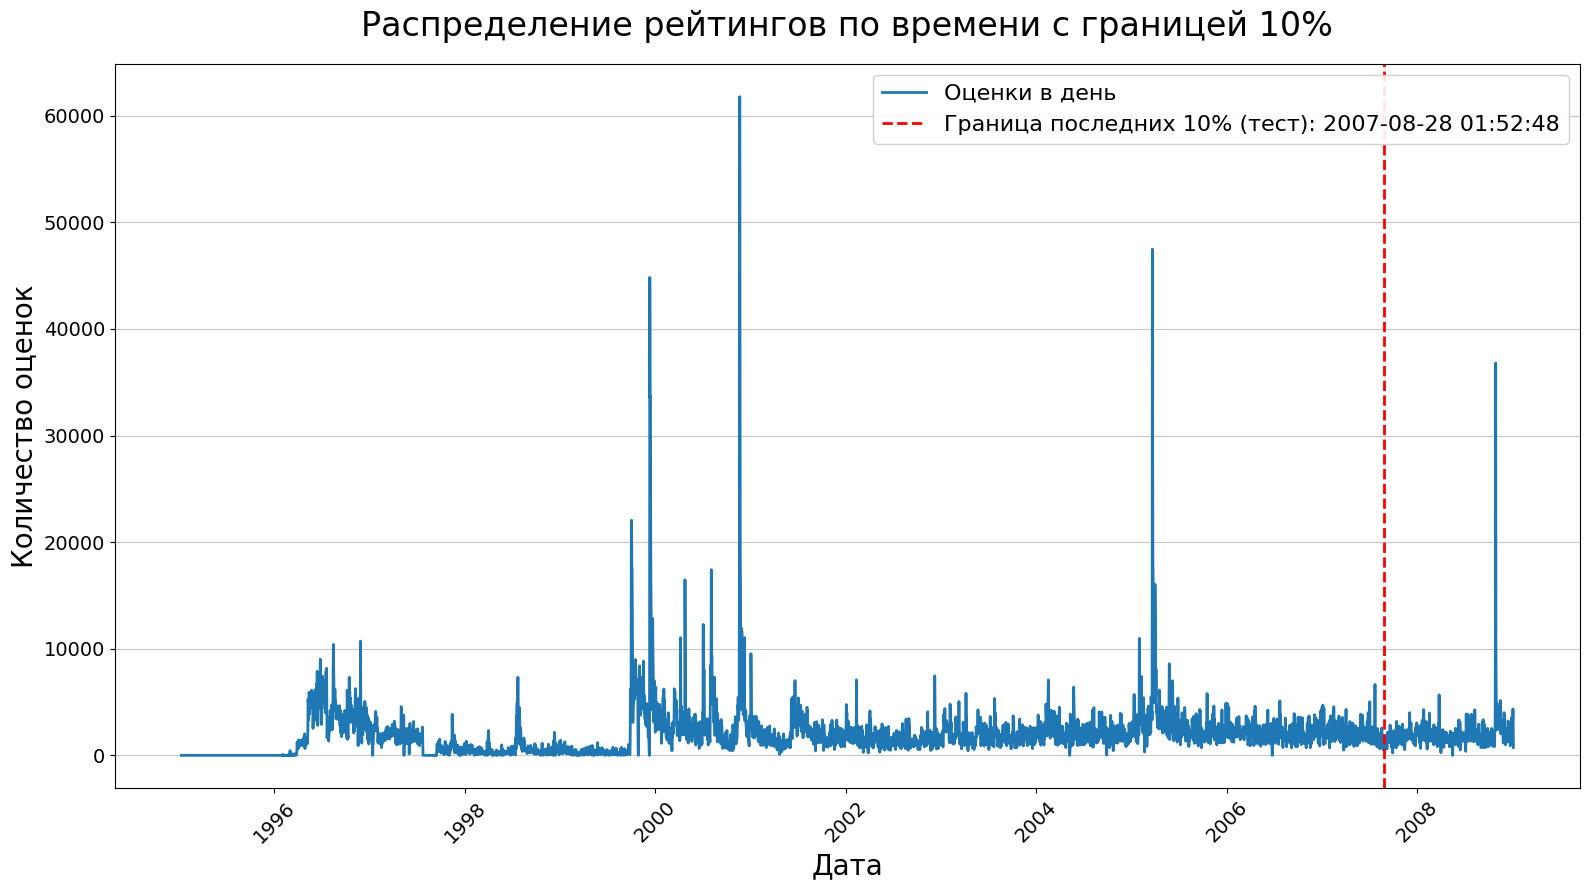

In [ ]:
ratings_df["date"] = pd.to_datetime(ratings_df["timestamp"], unit="s")
daily_counts = ratings_df.resample("D", on="date").size()

plt.figure(figsize=(16, 9))
plt.plot(daily_counts.index, daily_counts.values, linewidth=2, label="Оценки в день")
cutoff_date_date = pd.to_datetime(cutoff_date, unit="s")
plt.axvline(
    x=cutoff_date_date,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Граница последних 10% (тест): {cutoff_date_date}",
)

plt.title("Распределение рейтингов по времени с границей 10%", fontsize=24, pad=20)
plt.xlabel("Дата", fontsize=20)
plt.ylabel("Количество оценок", fontsize=20)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, framealpha=0.9)
plt.grid(True, axis="y", alpha=0.7)
plt.tight_layout()

plt.savefig("time_SEVERANCE.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# **Recommender System GPU**

Класс RecommenderSystemGPU включает алгоритмы: Collaborative(User-based, Item-based, SVD, ALS), Content-based(TF-IDF, BERT)

Использование GPU **рекомендуется** для быстрых вычислений при рекомендациях по SVD, ALS и Cotent-based(BERT)

Использование GPU **не дает** прироста в скорости при рекомендациях по User-based, Item-based, TF-IDF

In [ ]:
class RecommenderSystemGPU:
    def __init__(
        self,
        ratings_df,
        movies_df,
        model_type="user",
        content_method="tfidf",
        use_batches=True,
        batch_size=1024,
        k_neighbors=20,
        svd_n_epochs=10,
        svd_n_factors=64,
        svd_lr=1e-2,
        svd_weight_decay=1e-5,
        svd_batch_size=8192,
        svd_optimizer="SGD",
        svd_wandb_project="movielens_svd",
        svd_wandb_name="svd_64d_lr1e-2",
        als_n_factors=20,
        als_n_iterations=15,
        als_reg=0.1,
        seed=42,
        w_data = 0.52,
        w_crew = 0.38,
        w_title = 0.10
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = seed # def 42
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.model_type = model_type.lower()

        self.content_method = content_method

        self.batch_size = batch_size
        self.use_batches = use_batches

        self.k_neighbors = k_neighbors # def 20

        self.svd_n_epochs = svd_n_epochs # def 10
        self.svd_n_factors = svd_n_factors  # d - в ВКР, число факторов def 64
        self.svd_lr = svd_lr # def 0.01
        self.svd_weight_decay = svd_weight_decay # def 0.00001
        self.svd_batch_size = svd_batch_size # def 8192
        self.svd_model = None
        self.svd_fitted = False
        self.svd_optimizer=svd_optimizer
        self.svd_wandb_project=svd_wandb_project
        self.svd_wandb_name=svd_wandb_name

        self.als_n_factors = als_n_factors  # def 20
        self.als_n_iterations = als_n_iterations  # def 15
        self.als_reg = als_reg  # def 0.1

        self.w_data = w_data
        self.w_crew = w_crew
        self.w_title = w_title

        self.user_encoder = LabelEncoder()
        self.movie_encoder = LabelEncoder()
        self._prepare_data()
        self._precompute_means()

        # Выбор модели
        if self.model_type == "svd":
            self.model_name = "SVD PyTorch"
        elif self.model_type == "user":
            self.model_name = "User-based"
            self._precompute_user_similarities()
        elif self.model_type == "item":
            self.model_name = "Item-based"
        elif self.model_type == "als":
            self.model_name = "ALS"
        elif self.model_type == "content":
            self.model_name = "Контентная фильтрация"
            self._prepare_content_data()
        else:
            raise ValueError(f"Неизвестный тип модели: {self.model_type}")

    def _prepare_data(self):
        users = self.user_encoder.fit_transform(self.ratings_df['userId'])
        movies = self.movie_encoder.fit_transform(self.ratings_df['movieId'])
        self.ratings_matrix = csr_matrix((self.ratings_df['rating'], (users, movies)), dtype=np.float32)
        self.user_mean_rating = self.ratings_df.groupby('userId')['rating'].mean().to_dict()
        self.movie_mean_rating = self.ratings_df.groupby('movieId')['rating'].mean().to_dict()
        if self.model_type == "content":
            self.movie_encoder = LabelEncoder()
            self.movie_encoder.fit(self.movies_df['movieId'])

    def _precompute_means(self):
        # Средние по пользователю и фильму
        self.user_means = np.array([self.user_mean_rating.get(u, 0.0) for u in self.user_encoder.classes_], dtype=np.float32)
        self.movie_means = np.array([self.movie_mean_rating.get(m, 0.0) for m in self.movie_encoder.classes_], dtype=np.float32)
        self.global_mean_rating = float(sum(self.ratings_df['rating'])) / len(self.ratings_df['rating'])
        if self.model_type == "user" or self.model_type == "item":
            self.adjusted_ratings_user = self.ratings_matrix.copy() # центирированная по пользователям
            r, _ = self.adjusted_ratings_user.nonzero()
            self.adjusted_ratings_user.data -= self.user_means[r]

    def _precompute_user_similarities(self):
        # Используем уже центрированные рейтинги в self.adjusted_ratings_user (CSR)
        # Нормализуем каждую строку (по L2) для косинусного сходства эквивалентно корреляции после центрирования
        # Нормированная разреженная матрица
        self.normed_ratings = normalize(self.adjusted_ratings_user, axis=1)
        self.knn = NearestNeighbors(n_neighbors=self.k_neighbors, metric='cosine', algorithm='brute')
        self.knn.fit(self.normed_ratings)
        distances, indices = self.knn.kneighbors(self.normed_ratings, n_neighbors=self.k_neighbors)
        self.user_sim_matrix = {
            'indices': indices,
            'distances': distances
        }

    def _prepare_content_data(self):
        # Фильтрация по возрастным рейтингам и объединение текстовых полей
        self.ratings_order = ["G", "PG", "PG-13", "R", "NC-17", "Unknown"]
        # Заполнение отсутствующих
        self.movies_df["Rated"] = self.movies_df.get("Rated", pd.Series()).fillna("Unknown")
        self.movies_df["Rated"] = pd.Categorical(
            self.movies_df["Rated"], categories=self.ratings_order, ordered=True
        )
        self.movies_df["Rated_code"] = self.movies_df["Rated"].cat.codes

        self.content = (self.movies_df['clean_title'] + ' ' +
                        self.movies_df['genres'].str.join(' ') + ' ' +
                        self.movies_df.get('Director', '').fillna('') + ' ' +
                        self.movies_df.get('Actors', '').fillna('') + ' ' +
                        self.movies_df.get('Overview', '').fillna(''))

        self.content_data = (self.movies_df['genres'].str.join(' ') + ' ' +
                              self.movies_df.get('Overview', '').fillna(''))
        self.content_crew = (self.movies_df.get('Director', '').fillna('') + ' ' +
                             self.movies_df.get('Actors', '').fillna(''))

        if self.content_method == 'tfidf':
            vec_data = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2))
            X_data = vec_data.fit_transform(self.content_data)

            vec_crew = TfidfVectorizer(max_features=4000, stop_words='english')
            X_crew = vec_crew.fit_transform(self.content_crew)

            vec_title = TfidfVectorizer(max_features=2000, stop_words='english')
            X_title = vec_title.fit_transform(self.movies_df['clean_title'].fillna(''))

            X_weighted = hstack([X_data * self.w_data, X_crew * self.w_crew, X_title * self.w_title], format='csr')
            self.movie_features = normalize(X_weighted, axis=1).toarray()
            self.movie_features = torch.tensor(self.movie_features, device=self.device)
        else:
            if yandex:
                cache_path = f"/home/jupyter/datasphere/project/BERT_cache/bert_embeddings.joblib"
            else:
                cache_path = f"/content/drive/MyDrive/BERT_cache/bert_embeddings.joblib"
            if os.path.exists(cache_path):
                print("Loading cached BERT embeddings")
                emb = joblib.load(cache_path)
            else:
                print("Generating new BERT embeddings")
                model = SentenceTransformer('all-MiniLM-L6-v2', device=str(self.device))
                emb = model.encode(self.content.tolist(), convert_to_tensor=True, show_progress_bar=True) # Тензор
                joblib.dump(emb, cache_path)

            self.movie_features = F.normalize(emb, p=2, dim=1)
        # Словарь movieId -> индекс
        self.movieid_to_idx = {mid: idx for idx, mid in enumerate(self.movies_df['movieId'])}

    def _content_predict(self, user_ids):
        user_profiles = []

        for uid in user_ids:
            user_ratings = self.ratings_df[self.ratings_df['userId'] == uid]
            liked = user_ratings[user_ratings['rating'] >= 3.5]['movieId']
            idxs = [self.movieid_to_idx[mid] for mid in liked if mid in self.movieid_to_idx]

            if not idxs:
                profile = None
            else:
                if self.content_method == 'tfidf':
                    profile = self.movie_features[idxs].mean(axis=0)
                else:  # BERT
                    profile = torch.mean(self.movie_features[idxs], dim=0)

            user_profiles.append(profile)

        if self.content_method == 'tfidf':
            user_profiles = [
                p if p is not None else np.zeros((self.movie_features.shape[1],), dtype=np.float32)
                for p in user_profiles
            ]
            user_profiles = np.vstack(user_profiles)

            from sklearn.metrics.pairwise import cosine_similarity
            similarity = cosine_similarity(user_profiles, self.movie_features)
            similarity = torch.tensor(similarity, device=self.device)

        else:
            user_profiles = [
                p if p is not None else torch.zeros((self.movie_features.shape[1],), device=self.device)
                for p in user_profiles
            ]
            user_profiles = torch.stack(user_profiles)
            movie_matrix = F.normalize(self.movie_features, dim=1)
            user_profiles = F.normalize(user_profiles, dim=1)
            similarity = user_profiles @ movie_matrix.T  # (batch, num_movies)
        # Фильтрация по возрастному рейтингу
        mask = torch.ones_like(similarity, dtype=torch.bool, device=self.device)
        for i, uid in enumerate(user_ids):
            user_ratings = self.ratings_df[self.ratings_df['userId'] == uid]
            liked = user_ratings[user_ratings['rating'] >= 3.5]['movieId']
            if not liked.empty:
                max_code = self.movies_df.loc[self.movies_df['movieId'].isin(liked), 'Rated_code'].max()
                user_mask = self.movies_df['Rated_code'].values <= max_code
                mask[i] = torch.tensor(user_mask, device=self.device)
        similarity[~mask] = -float('inf') # совместимость PyTorch и numPy
        return similarity

    def get_model_name(self):
        return self.model_name

    def fit(self):
        # Обучение моделей
        if self.model_type == 'svd':
            self._fit_svd()
            self.fitted=True

        elif self.model_type == 'als':
            self._fit_als()

        elif self.model_type == 'item':
            # Матрица item-item
            dense = torch.tensor(self.adjusted_ratings_user.T.toarray(), device=self.device)
            norm = F.normalize(dense, p=2, dim=1)
            self.item_sim = norm @ norm.T
            topk_values, topk_indices = torch.topk(self.item_sim, k=self.k_neighbors, dim=1)
            self.item_sim = torch.zeros_like(self.item_sim).scatter_(1, topk_indices, topk_values)
        # user-based готова в __init__

    def _fit_svd(self):
        if self.svd_wandb_project:
            wandb.init(project=self.svd_wandb_project, name=self.svd_wandb_name)
        self.ratings_matrix = self.ratings_matrix.tocoo()
        user_ids = torch.tensor(self.ratings_matrix.row, dtype=torch.long)
        item_ids = torch.tensor(self.ratings_matrix.col, dtype=torch.long)
        ratings = torch.tensor(self.ratings_matrix.data, dtype=torch.float32)

        g = torch.Generator()
        g.manual_seed(self.seed)
        dataset = RatingDataset(user_ids, item_ids, ratings)
        loader = DataLoader(dataset, batch_size=self.svd_batch_size, shuffle=True, generator=g)

        num_users, num_items = self.ratings_matrix.shape

        self.model = SVDTorchModel(num_users, num_items, self.svd_n_factors).to(self.device)
        if self.svd_optimizer == 'Adam':
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.svd_lr, weight_decay=self.svd_weight_decay)
        else:
            optimizer = torch.optim.SGD(self.model.parameters(), lr=self.svd_lr, weight_decay=self.svd_weight_decay)
        loss_fn = nn.MSELoss()

        for epoch in range(self.svd_n_epochs):
            self.model.train()
            total_loss = 0
            for batch_user_ids, batch_item_ids, batch_ratings in tqdm(loader, desc=f"Epoch {epoch+1}/{self.svd_n_epochs}"):
                batch_user_ids = batch_user_ids.to(self.device)
                batch_item_ids = batch_item_ids.to(self.device)
                batch_ratings = batch_ratings.to(self.device)

                preds = self.model(batch_user_ids, batch_item_ids)
                loss = loss_fn(preds, batch_ratings)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * len(batch_ratings)

            rmse = np.sqrt(total_loss / len(dataset))
            print(f"Epoch {epoch+1}: RMSE={rmse:.4f}")

            if self.svd_wandb_project:
                wandb.log({"epoch": epoch + 1, "rmse": rmse})

        return self.model

    def _fit_als(self):
        from collections import defaultdict
        if self.svd_wandb_project:
            wandb.init(project=self.svd_wandb_project, name=self.svd_wandb_name)
        self.ratings_matrix = self.ratings_matrix.tocoo()
        user_ids = torch.tensor(self.ratings_matrix.row, dtype=torch.long)
        item_ids = torch.tensor(self.ratings_matrix.col, dtype=torch.long)
        ratings = torch.tensor(self.ratings_matrix.data, dtype=torch.float32)

        n_users, n_items = self.ratings_matrix.shape

        dtype = torch.float16
        U = torch.empty((n_users, self.als_n_factors), device=self.device, dtype=dtype).uniform_(-0.01, 0.01)
        V = torch.empty((n_items, self.als_n_factors), device=self.device, dtype=dtype).uniform_(-0.01, 0.01)
        ub = torch.zeros(n_users, device=self.device, dtype=dtype)
        ib = torch.zeros(n_items, device=self.device, dtype=dtype)

        user_ids = torch.tensor(self.ratings_matrix.row, dtype=torch.long)
        item_ids = torch.tensor(self.ratings_matrix.col, dtype=torch.long)
        ratings = torch.tensor(self.ratings_matrix.data, dtype=torch.float32)

        I = torch.eye(self.als_n_factors, device=self.device)

        user_rated = defaultdict(list)
        item_rated = defaultdict(list)
        for u, i, r in zip(user_ids.tolist(), item_ids.tolist(), ratings.tolist()):
            user_rated[u].append((i, r))
            item_rated[i].append((u, r))

        def batched(iterable, batch_size):
            items = list(iterable)
            for i in range(0, len(items), batch_size):
                yield items[i:i + batch_size]

        @torch.compile(mode="reduce-overhead")
        def _als_iteration(U, V, ub, ib):
            for it in range(self.als_n_iterations):
                # === Update U ===
                for batch in batched(user_rated.items(), self.batch_size):
                    users, data = zip(*batch)
                    B = len(users)
                    max_len = max(len(pairs) for pairs in data)

                    Vi = torch.zeros((B, max_len, self.als_n_factors), dtype=dtype, device=self.device)
                    Ri = torch.zeros((B, max_len), dtype=dtype, device=self.device)

                    for i, pairs in enumerate(data):
                        for j, (item_id, r_ui) in enumerate(pairs):
                            Vi[i, j] = V[item_id]
                            Ri[i, j] = r_ui - ib[item_id] - self.global_mean_rating

                    A = Vi.transpose(1, 2) @ Vi + self.als_reg * I.unsqueeze(0)
                    b = (Vi.transpose(1, 2) @ Ri.unsqueeze(-1)).squeeze(-1)
                    b = b.to(dtype=A.dtype)
                    U[users] = torch.linalg.solve(A, b)

                    for i, u in enumerate(users):
                        pred = Vi[i][:len(data[i])] @ U[u]
                        ub[u] = (Ri[i][:len(data[i])].sum() - pred.sum()) / len(data[i])

                # === Update V ===
                for batch in batched(item_rated.items(), self.batch_size):
                    items, data = zip(*batch)
                    B = len(items)
                    max_len = max(len(pairs) for pairs in data)

                    Ui = torch.zeros((B, max_len, n_factors), dtype=dtype, device=self.device)
                    Ri = torch.zeros((B, max_len), dtype=dtype, device=self.device)

                    for i, pairs in enumerate(data):
                        for j, (user_id, r_ui) in enumerate(pairs):
                            Ui[i, j] = U[user_id]
                            Ri[i, j] = r_ui - ub[user_id] - self.global_mean_rating

                    A = Ui.transpose(1, 2) @ Ui + self.als_reg * I.unsqueeze(0)
                    b = (Ui.transpose(1, 2) @ Ri.unsqueeze(-1)).squeeze(-1)
                    b = b.to(dtype=A.dtype)
                    V[items] = torch.linalg.solve(A, b)

                    for i, v in enumerate(items):
                        pred = Ui[i][:len(data[i])] @ V[v]
                        ib[v] = (Ri[i][:len(data[i])].sum() - pred.sum()) / len(data[i])

            return U, V, ub, ib

        self.U, self.V, self.ub, self.ib = _als_iteration(U, V, ub, ib)

    def recommend_items(self, user_ids, rated_movies=None, top_n=10):
        if isinstance(user_ids, (int, np.integer)):
            user_ids = [user_ids]
            single_user = True
        else:
            single_user = False

        if rated_movies is None:
            rated_movies = [set() for _ in user_ids]
        elif isinstance(rated_movies, set):
            rated_movies = [rated_movies]
        elif isinstance(rated_movies, list) and all(isinstance(x, (list, set)) for x in rated_movies):
            rated_movies = [set(x) for x in rated_movies]

        with torch.no_grad():
            uidxs = self.user_encoder.transform(user_ids)

            if self.model_type == "svd":
                self.model.eval()
                all_item_idx = torch.arange(len(self.movie_encoder.classes_), device=self.device, dtype=torch.long)
                user_idx_t = torch.tensor(uidxs, device=self.device, dtype=torch.long)
                scores = []

                for uid in user_idx_t:
                    uid_exp = uid.repeat(len(all_item_idx))
                    with torch.no_grad():
                        user_scores = self.model(uid_exp, all_item_idx).cpu().numpy()
                    scores.append(user_scores)

                scores = np.stack(scores)

            elif self.model_type == "als":
                scores = (self.U[uidxs] @ self.V.T)
                scores += (self.ib + self.ub[uidxs]+ self.global_mean_rating)
                scores = scores.cpu().numpy()

            elif self.model_type == 'content':
                scores = self._content_predict(user_ids).cpu().numpy()

            elif self.model_type == 'user':
                indices = self.user_sim_matrix['indices'][uidxs]
                distances = self.user_sim_matrix['distances'][uidxs]

                sims = 1 - distances
                topk_users = indices

                flat_indices = topk_users.ravel()
                neigh_ratings_flat = self.adjusted_ratings_user[flat_indices]

                neigh_ratings = neigh_ratings_flat.toarray().reshape(
                    len(uidxs), self.k_neighbors, -1
                )

                weights = sims.reshape(-1, self.k_neighbors, 1)
                scores = (neigh_ratings * weights).sum(axis=1) / (np.abs(weights).sum(axis=1) + 1e-10)

                scores += self.user_means[uidxs].reshape(-1, 1)

            elif self.model_type == "item":
                user_vecs = self.adjusted_ratings_user[uidxs].toarray()
                scores = (torch.tensor(user_vecs, device=self.device) @ self.item_sim).cpu().numpy()

            else:
                raise NotImplementedError(f"Модель {self.model_type} не реализована")
        # Фильтрация уже просмотренных фильмов
        for i, seen in enumerate(rated_movies):
            mask = np.isin(self.movie_encoder.classes_, list(seen))
            scores[i, mask] = -np.inf
        # Формирование рекомендаций
        recommendations = []
        for user_scores in scores:
            top_indices = np.argpartition(user_scores, -top_n)[-top_n:]
            top_indices = top_indices[np.argsort(user_scores[top_indices])[::-1]]
            rec_df = pd.DataFrame({
                'movieId': self.movie_encoder.classes_[top_indices],
                'score': user_scores[top_indices]
            })
            recommendations.append(rec_df)
        return recommendations[0] if single_user else recommendations

    def recommend_items_bulk(self, user_ids, seen_sets, top_n=10):
        recs = []
        if self.use_batches:
            total_users = len(user_ids)
            for start in tqdm(range(0, total_users, self.batch_size), desc="Bulk рекомендации"):
                end = min(start + self.batch_size, total_users)
                batch_users = user_ids[start:end]
                batch_seen = seen_sets[start:end]
                try:
                    batch_recs = self.recommend_items(batch_users, batch_seen, top_n)
                    for rec_df in batch_recs:
                        recs.append(rec_df["movieId"].tolist())
                except Exception as e:
                    print(f"Ошибка при обработке пользователей {start}-{end}: {e}")
                    recs.extend([[]] * (end - start))
        else:
            for uid, seen in tqdm(zip(user_ids, seen_sets), desc="Bulk рекомендации"):
                try:
                    rec_df = self.recommend_items(uid, seen, top_n)
                    recs.append(rec_df["movieId"].tolist())
                except Exception as e:
                    print(f'Пользователь {uid} вызвал исключение: {e}')
                    recs.append([])
        return recs

    def predict_rating(self, user_id, movie_id):
        if movie_id not in self.movie_encoder.classes_:
            return float(self.ratings_df['rating'].mean())

        try:
            uidx = self.user_encoder.transform([user_id])[0]
            midx = self.movie_encoder.transform([movie_id])[0]
        except ValueError as e:
            if "unseen labels" in str(e):
                return float(self.ratings_df['rating'].mean())
            return None

        if self.model_type == "als":
            return (self.U[uidx] @ self.V[midx] +
                    self.ub[uidx] +
                    self.ib[midx] +
                    self.global_mean_rating).item()

        elif self.model_type == "svd":
            self.model.eval()
            with torch.no_grad():
                user_tensor = torch.tensor([uidx], dtype=torch.long).to(self.device)
                item_tensor = torch.tensor([midx], dtype=torch.long).to(self.device)
                pred = self.model(user_tensor, item_tensor).item() # Уже веключены биасы и глобальное среднее
            return float(pred)

        elif self.model_type == 'user':
            # Данные соседей в разреженном формате
            similarities = 1 - self.user_sim_matrix['distances'][uidx]
            neighbors = self.user_sim_matrix['indices'][uidx]

            # Получаем рейтинги соседей в разреженном формате
            ratings = self.ratings_matrix[neighbors, midx]

            # Обработка случая, когда нет оценок
            if ratings.nnz == 0:
                return float(self.user_means[uidx])

            # Извлекаем ненулевые элементы
            valid_ratings = ratings.data
            valid_indices = ratings.indices
            valid_sims = similarities[valid_indices]

            # Векторизованные вычисления
            weighted_diff = np.sum(valid_sims * (valid_ratings - self.user_means[neighbors[valid_indices]]))
            sum_sims = np.sum(np.abs(valid_sims))

            # Защита от деления на ноль
            if sum_sims < 1e-10:
                return float(self.user_means[uidx])

            return float(self.user_means[uidx] + weighted_diff / sum_sims)

        elif self.model_type == 'item':
            similarities = self.item_sim[midx]
            if hasattr(similarities, 'cpu'):
                similarities = similarities.cpu().numpy()

            ratings = self.adjusted_ratings_user[uidx]
            if hasattr(ratings, 'toarray'):
                ratings = ratings.toarray().flatten()
            elif hasattr(ratings, 'cpu'):
                ratings = ratings.cpu().numpy()

            valid_mask = similarities > 0
            if not np.any(valid_mask):
                return float(self.user_means[uidx])

            # Векторизованные вычисления
            weighted_sum = np.sum(similarities[valid_mask] * ratings[valid_mask])
            sum_sim = np.sum(similarities[valid_mask])

            return float(self.user_means[uidx] + weighted_sum / sum_sim if sum_sim > 1e-10
                      else self.user_means[uidx])

        elif self.model_type == "content":
            return float(self._content_predict(user_id)[midx].item())

        return None

    def predict_bulk(self, user_ids, movie_ids):
        if len(user_ids) == 0 or len(movie_ids) == 0:
            return []
        # Векторизованное преобразование ID
        try:
            uindices = self.user_encoder.transform(user_ids)
            mindices = self.movie_encoder.transform(movie_ids)
        except ValueError as e:
            print(f"Ошибка преобразования ID: {str(e)}")
            return [np.nan] * len(user_ids)

        # if self.model_type == 'item':
        #     return [self.predict_rating(uid, mid) for uid, mid in zip(user_ids, movie_ids)]

        results = np.zeros(len(user_ids))

        if self.model_type == 'user':
            for i, (uidx, midx) in enumerate(tqdm(zip(uindices, mindices), total=len(user_ids))):
                similarities = 1 - self.user_sim_matrix['distances'][uidx]
                neighbors = self.user_sim_matrix['indices'][uidx]

                ratings = self.ratings_matrix[neighbors, midx]

                if ratings.nnz == 0:
                    results[i] = self.user_means[uidx]
                    continue

                valid_ratings = ratings.data
                valid_indices = ratings.indices
                valid_sims = similarities[valid_indices]
                weighted_diff = np.sum(valid_sims * (valid_ratings - self.user_means[neighbors[valid_indices]]))
                sum_sims = np.sum(np.abs(valid_sims))

                if sum_sims >= 1e-10:
                    results[i] = self.user_means[uidx] + weighted_diff / sum_sims
                else:
                    results[i] = self.user_means[uidx]
        elif self.model_type == 'item':
            for i, (uidx, midx) in enumerate(tqdm(zip(uindices, mindices), total=len(user_ids))):
                try:
                    results[i] = self.predict_rating(uidx, midx)
                except Exception as e:
                    if self.detailed:
                        print(f"Ошибка предсказания для пары {i}: {str(e)}")
                    results[i] = self._get_fallback_rating(uidx)
        elif self.model_type == 'svd':
            self.model.eval()
            with torch.no_grad():
                user_tensor = torch.tensor(uindices, dtype=torch.long).to(self.device)
                item_tensor = torch.tensor(mindices, dtype=torch.long).to(self.device)
                preds = self.model(user_tensor, item_tensor).cpu().numpy()
            return preds.tolist()

        return results.tolist()

    def save_model(self):
        if self.model_type == "content":
            self.save = self.model_type + "_" + self.content_method
            if yandex:
                path = f"/home/jupyter/datasphere/project/{self.save}_gpu.pt"
            else:
                path = f"/content/drive/MyDrive/{self.save}_gpu.pt"
        else:
            if yandex:
                path = f"/home/jupyter/datasphere/project/{self.model_type}_gpu.pt"
            else:
                path = f"/content/drive/MyDrive/{self.model_type}_gpu.pt"
        # Сохраняем state_dict и энкодеры
        model_data = {
            "model_type": self.model_type,
            "encoders": {"user": self.user_encoder, "movie": self.movie_encoder},
            "model_state": {},
            "metadata": {
                "content_method": self.content_method,
                "k_neighbors": getattr(self, 'k_neighbors', 20),
                "svd_n_epochs": getattr(self, 'svd_n_epochs', 20),
                "svd_n_factors": getattr(self, 'svd_n_factors', 200),
                "als_n_factors": getattr(self, 'als_n_factors', 20),
                "als_n_iterations": getattr(self, 'als_n_iterations', 15),
                "als_reg": getattr(self, 'als_reg', 0.1)
            }
        }
        if self.model_type == "svd":
            self.model.save(path)
        elif self.model_type == "als":
            model_data["model_state"] = {"U": self.U.cpu(),
                                         "V": self.V.cpu(),
                                         "ub": self.ub.cpu(),
                                         "ib": self.ib.cpu()}
        elif self.model_type == "content":
            model_data["model_state"] = {"movie_features": self.movie_features}
            model_data["model_state"] = {"movieid_to_idx": self.movieid_to_idx,}
        elif self.model_type == "user":
            model_data["model_state"] = {"knn": self.knn,
                                         "normed_ratings": self.normed_ratings,
                                         "user_sim_matrix": self.user_sim_matrix}
        elif self.model_type == "item":
            model_data["model_state"] = {"item_sim": self.item_sim}
        torch.save(model_data, path)

    def load_model(self):
        if self.model_type == "content":
            self.save = self.model_type + "_" + self.content_method
            if yandex:
                path = f"/home/jupyter/datasphere/project/{self.save}_gpu.pt"
            else:
                path = f"/content/drive/MyDrive/{self.save}_gpu.pt"
        else:
            if yandex:
                path = f"/home/jupyter/datasphere/project/{self.model_type}_gpu.pt"
            else:
                path = f"/content/drive/MyDrive/{self.model_type}_gpu.pt"
        ckpt = torch.load(path, map_location=self.device, weights_only=False)
        self.model_type = ckpt["model_type"]
        self.user_encoder = ckpt["encoders"]["user"]
        self.movie_encoder = ckpt["encoders"]["movie"]

        if self.model_type == 'als':
            st = ckpt["model_state"]
            self.U = st["U"].to(self.device)
            self.V = st["V"].to(self.device)
            self.ub = st["ub"].to(self.device)
            self.ib = st["ib"].to(self.device)
            self.als_n_iterations = ckpt["metadata"]["als_n_iterations"]
            self.als_reg = ckpt["metadata"]["als_reg"]
            self.als_n_factors = ckpt["metadata"]["als_n_factors"]
        elif self.model_type == "svd":
            st = ckpt["model_state"]
            self.svd_n_factors = ckpt["metadata"]["svd_n_factors"]
            self.model = SVDTorchModel(len(self.user_encoder.classes_), len(self.movie_encoder.classes_), self.svd_n_factors).to(self.device)
            self.model.load(path)
            self.fitted = True
        elif self.model_type == "item":
            st = ckpt["model_state"]
            self.k_neighbors = ckpt["metadata"]["k_neighbors"]
            self.item_sim = st["item_sim"].to(self.device)
        elif self.model_type == "user":
            st = ckpt["model_state"]
            self.k_neighbors = ckpt["metadata"]["k_neighbors"]
            self.knn = st["knn"]
            self.normed_ratings = st["normed_ratings"]
            self.user_sim_matrix = st["user_sim_matrix"]
        elif self.model_type == "content":
            st = ckpt["model_state"]
            self.content_method = ckpt["metadata"]["content_method"]
            self.movie_features = st["movie_features"]
            self.movieid_to_idx = st["movieid_to_idx"]

# **Evaluator**

Класс призван оценивать модели из класса Recommender System GPU

Объяснение переменных:
```
recommender_system: оцениваемая модель класса RecommenderSystemGPU

train_df: обучающая выборка

test_df: тестовая выборка

k: количество показываемых фильмов, обычное значение 10
```
Взаимодействие с Recommender System GPU: вызывает функцию recommend_items_bulk(user_ids, seen_sets, top_n) и rmse_surprise_svd(test_df)

In [ ]:
class RecommenderEvaluator:
    def __init__(self, recommender_system, train_df, test_df, k=10, rating_threshold=3.5, detailed=True):
        self.recommender_system = recommender_system
        self.train_df = train_df
        self.test_df = test_df
        self.top_n = k
        self.rating_threshold = rating_threshold
        self.detailed = detailed

        self.test_df = self.test_df[self.test_df['userId'].isin(train_df['userId'].unique())]
        self.test_df = self.test_df[self.test_df['movieId'].isin(train_df['movieId'].unique())]
        filtered_test_df = self.test_df[self.test_df['rating'] >= rating_threshold]

        # userId -> множество релевантных movieId
        self.test_user_items = filtered_test_df.groupby('userId')['movieId'].apply(set).to_dict()

        # userId -> {movieId: rating} (все оценки, для NDCG)
        self.test_user_ratings = self.test_df.groupby('userId').apply(
            lambda x: dict(zip(x['movieId'], x['rating']))
        ).to_dict()


    def evaluate(self):
        users = self.test_df['userId'].unique()
        if len(users) == 0:
            return {f'Precision@{self.top_n}': 0.0,
                    f'Recall@{self.top_n}': 0.0,
                    f'F1@{self.top_n}': 0.0,
                    f'MAP@{self.top_n}': 0.0,
                    f'NDCG@{self.top_n}': 0.0,
                    'Coverage': 0.0,
                    'Personalization': 0.0}

        # Списки фильмов, которые видел каждый пользователь в трейне
        seen = self.train_df.groupby('userId')['movieId'].apply(set).to_dict()
        user_seen = [seen.get(u, set()) for u in users]
        # Пакетные рекомендации
        recs = []
        recommendations = self.recommender_system.recommend_items_bulk(users, user_seen, self.top_n)

        for batch in recommendations:
            # DataFrame с колонками ['movieId', 'score']
            if isinstance(batch, pd.DataFrame):
                recs.append(batch['movieId'].tolist())

            # список словарей {'movieId': ..., 'score': ...}
            elif isinstance(batch, list) and batch and isinstance(batch[0], dict):
                recs.append([item['movieId'] for item in batch])

            # список просто movieId (TF-IDF)
            elif isinstance(batch, list) and batch and isinstance(batch[0], int):
                recs.append(batch)

            # всё остальное — пустая рекомендация
            else:
                recs.append([])

        metrics = self.evaluate_topk_metrics(users, recs)
        metrics.update(self.evaluate_coverage(recs))
        metrics.update(self.evaluate_personalization(recs))

        if self.detailed:
            print(f"Обработано пользователей: {len(users)}")
        return metrics

    def evaluate_topk_metrics(self, users, recs):
        metrics = {
            f'Precision@{self.top_n}': [],
            f'Recall@{self.top_n}': [],
            f'F1@{self.top_n}': [],
            f'MAP@{self.top_n}': [],
            f'NDCG@{self.top_n}': []
        }

        for u, rec in zip(users, recs):
            actual = self.test_user_items.get(u, set())
            if not actual or not rec:
                continue

            rec = rec[:self.top_n] # Список рекомендаций
            hit = set(rec) & actual
            prec = len(hit) / self.top_n # Precision@k
            recall = len(hit) / len(actual) # Recall@k
            f1 = 2 * prec * recall / (prec + recall) if (prec + recall) > 0 else 0.0 # F1@k
            # MAP@k
            ap = 0.0
            hits = 0
            for pos, item in enumerate(rec, 1):
                if item in actual:
                    hits += 1
                    ap += hits / pos
            mapk = ap / min(hits, len(actual)) if hits > 0 else 0.0
            # NDCG@k
            ndcg = 0.0
            actual_ratings = self.test_user_ratings.get(u, {})
            if actual_ratings:
                ideal_ratings = sorted(actual_ratings.values(), reverse=True)[:self.top_n]
                idcg = sum((r / np.log2(i + 1)) for i, r in enumerate(ideal_ratings, 1))
                dcg = sum(actual_ratings.get(item, 0) / np.log2(pos + 1) for pos, item in enumerate(rec, 1))
                ndcg = dcg / idcg if idcg > 0 else 0.0

            metrics[f'Precision@{self.top_n}'].append(prec)
            metrics[f'Recall@{self.top_n}'].append(recall)
            metrics[f'F1@{self.top_n}'].append(f1)
            metrics[f'MAP@{self.top_n}'].append(mapk)
            metrics[f'NDCG@{self.top_n}'].append(ndcg)

        final_metrics = {k: np.mean(v) if v else 0.0 for k, v in metrics.items()}
        return final_metrics

    def evaluate_coverage(self, recs):
        all_items = set(self.train_df['movieId'].unique()) | set(self.test_df['movieId'].unique())
        recommended_items = set()
        for rec in recs:
            recommended_items.update(rec[:self.top_n])
        coverage = len(recommended_items) / len(all_items) if all_items else 0.0
        if self.detailed:
            print(f"Всего рекомендованных фильмов: {len(recommended_items)}")
        return {'Coverage': coverage}

    def evaluate_personalization(self, recs, sample_size=5000):
        if len(recs) > sample_size:
            indices = np.random.choice(len(recs), size=sample_size, replace=False)
            recs = [recs[i] for i in indices]

        all_items = [item for rec in recs for item in rec[:self.top_n]]
        if not all_items:
            return {'Personalization': 0.0}

        per_le = LabelEncoder()
        per_le.fit(all_items)

        rows, cols = [], []
        for i, rec in enumerate(recs):
            for item in rec[:self.top_n]:
                rows.append(i)
                cols.append(per_le.transform([item])[0])

        data = np.ones(len(rows))
        user_item_matrix = csr_matrix((data, (rows, cols)),
                                  shape=(len(recs), len(per_le.classes_)))

        distances = cosine_distances(user_item_matrix)
        personalization = distances[np.triu_indices(len(recs), k=1)].mean()
        return {'Personalization': personalization}

    def evaluate_rmse(self):
        # Подготовка данных
        test_pairs = self.test_df[['userId', 'movieId', 'rating']]
        actual_ratings = test_pairs['rating'].values

        # Получаем все предсказания за один вызов
        predicted = self.recommender_system.predict_bulk(
            test_pairs['userId'].tolist(),
            test_pairs['movieId'].tolist()
        )

        # Фильтруем некорректные предсказания
        valid_mask = ~np.isnan(predicted)
        actual = actual_ratings[valid_mask]
        predicted = np.array(predicted)[valid_mask]

        if len(actual) == 0:
            return {'RMSE': np.nan}

        return {'RMSE': np.sqrt(mean_squared_error(actual, predicted))}

# SVD Surprise

In [ ]:
class RatingDataset(Dataset):
    def __init__(self, user_ids, item_ids, ratings):
        self.user_ids = user_ids
        self.item_ids = item_ids
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.ratings[idx]

class SVDTorchModel(nn.Module):
    def __init__(self, num_users, num_items, n_factors=64):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.P = nn.Embedding(num_users, n_factors).to(self.device) # U * Sigma
        self.Q = nn.Embedding(num_items, n_factors).to(self.device) # VT
        self.user_bias = nn.Embedding(num_users, 1).to(self.device)
        self.item_bias = nn.Embedding(num_items, 1).to(self.device)
        self.global_bias = nn.Parameter(torch.tensor([0.0])).to(self.device)

        nn.init.normal_(self.P.weight, std=0.1)
        nn.init.normal_(self.Q.weight, std=0.1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        mu = self.global_bias
        # output
        if len(b_u) < 2:
          outputs = mu + torch.squeeze(b_u) + torch.squeeze(b_i) + (P_u * Q_i).sum()
        else:
          outputs = mu + torch.squeeze(b_u) + torch.squeeze(b_i) + (P_u * Q_i).sum(axis=1)
        return outputs.flatten()

    def predict(self, user_ids, item_ids):
        self.eval()
        with torch.no_grad():
            return self.forward(user_ids, item_ids)

    def save(self, path):
        torch.save(self.state_dict(), path + ".pt")

    def load(self, path):
        self.load_state_dict(torch.load(path + ".pt"))

In [ ]:
# Разделение(train/test) по времени
train_df = timed_train_df
test_df = timed_test_df

recsys_svd = RecommenderSystemGPU(ratings_df=train_df,
                                  movies_df=movies_df,
                                  model_type="svd",
                                  svd_n_epochs=20,
                                  svd_n_factors=128,
                                  svd_lr=1e-1,
                                  svd_weight_decay=1e-5,
                                  svd_batch_size=8192,
                                  svd_optimizer="SGD")
recsys_svd.fit()
recsys_svd.save_model()
# recsys_svd.load_model()
recsys_svd_10_eval = RecommenderEvaluator(recsys_svd, train_df, test_df, k=10)
svd_at_10 = recsys_svd_10_eval.evaluate()
print(svd_at_10)
rmse_at_10 = recsys_svd_10_eval.evaluate_rmse()
print(rmse_at_10)
recsys_svd_20_eval = RecommenderEvaluator(recsys_svd, train_df, test_df, k=20)
svd_at_20 = recsys_svd_20_eval.evaluate()
print(svd_at_20)
rmse_at_20 = recsys_svd_20_eval.evaluate_rmse()
print(rmse_at_20)

wandb: Finishing previous runs because reinit is set to 'default'.
wandb: uploading output.log; uploading wandb-summary.json; uploading config.yaml
wandb: uploading summary, console lines 0-0
wandb:                                                                                
wandb: 🚀 View run svd_64d_lr1e-2 at: https://wandb.ai/superfunnygun-peoples-friendship-university-of-russia/movielens_svd/runs/te48odgs
wandb: ⭐️ View project at: https://wandb.ai/superfunnygun-peoples-friendship-university-of-russia/movielens_svd
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250524_194356-te48odgs/logs
wandb: Tracking run with wandb version 0.19.11
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20250524_195101-kpojyazb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run svd_64d_lr1e-2
wandb: ⭐️ View project at https://wandb.ai/superfunnygun-peoples-friendship-university-of-russia

Epoch 1: RMSE=3.3856


Epoch 2/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.87it/s]


Epoch 2: RMSE=2.9523


Epoch 3/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.83it/s]


Epoch 3: RMSE=2.6592


Epoch 4/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.81it/s]


Epoch 4: RMSE=2.4459


Epoch 5/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.81it/s]


Epoch 5: RMSE=2.2823


Epoch 6/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.82it/s]


Epoch 6: RMSE=2.1522


Epoch 7/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.81it/s]


Epoch 7: RMSE=2.0459


Epoch 8/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.79it/s]


Epoch 8: RMSE=1.9571


Epoch 9/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.80it/s]


Epoch 9: RMSE=1.8819


Epoch 10/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.87it/s]


Epoch 10: RMSE=1.8173


Epoch 11/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.82it/s]


Epoch 11: RMSE=1.7611


Epoch 12/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.83it/s]


Epoch 12: RMSE=1.7119


Epoch 13/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.83it/s]


Epoch 13: RMSE=1.6684


Epoch 14/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.80it/s]


Epoch 14: RMSE=1.6296


Epoch 15/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.85it/s]


Epoch 15: RMSE=1.5949


Epoch 16/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.88it/s]


Epoch 16: RMSE=1.5637


Epoch 17/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.87it/s]


Epoch 17: RMSE=1.5354


Epoch 18/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.85it/s]


Epoch 18: RMSE=1.5098


Epoch 19/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.82it/s]


Epoch 19: RMSE=1.4863


Epoch 20/20: 100%|██████████| 1099/1099 [01:41<00:00, 10.86it/s]

Epoch 20: RMSE=1.4648



/tmp/ipykernel_3550/3369494552.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Всего рекомендованных фильмов: 263
Обработано пользователей: 2788
{'Precision@10': np.float64(0.09624635568513121), 'Recall@10': np.float64(0.03578186155416619), 'F1@10': np.float64(0.03808713555844047), 'MAP@10': np.float64(0.18798213395065402), 'NDCG@10': np.float64(0.10760172087953877), 'Coverage': 0.027455893099488465, 'Personalization': np.float64(0.7752343453593471)}
{'RMSE': np.float64(2.8190925260792374)}


/tmp/ipykernel_3550/3369494552.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Всего рекомендованных фильмов: 401
Обработано пользователей: 2788
{'Precision@20': np.float64(0.08458454810495628), 'Recall@20': np.float64(0.05845748291513405), 'F1@20': np.float64(0.04971563892396411), 'MAP@20': np.float64(0.17471598378201733), 'NDCG@20': np.float64(0.10504423400951649), 'Coverage': 0.041862407349410165, 'Personalization': np.float64(0.724042297220287)}
{'RMSE': np.float64(2.8190925260792374)}


In [ ]:
# Случайное разделение(train/test)
train_df = random_train_df
test_df = random_test_df

test_df_filtered = test_df[test_df['userId'].isin(train_df['userId'].unique())]
recsys_svd = RecommenderSystemGPU(ratings_df=train_df,
                                  movies_df=movies_df,
                                  model_type="svd",
                                  svd_n_epochs=20,
                                  svd_n_factors=128,
                                  svd_lr=1e-1,
                                  svd_weight_decay=1e-5,
                                  svd_batch_size=8192,
                                  svd_optimizer="SGD")
recsys_svd.fit()
recsys_svd.save_model()
# recsys_svd.load_model()
recsys_svd_10_eval = RecommenderEvaluator(recsys_svd, train_df, test_df, k=10)
svd_at_10 = recsys_svd_10_eval.evaluate()
print(svd_at_10)
rmse_at_10 = recsys_svd_10_eval.evaluate_rmse()
print(rmse_at_10)
recsys_svd_20_eval = RecommenderEvaluator(recsys_svd, train_df, test_df, k=20)
svd_at_20 = recsys_svd_20_eval.evaluate()
print(svd_at_20)
rmse_at_20 = recsys_svd_20_eval.evaluate_rmse()
print(rmse_at_20)

wandb: Finishing previous runs because reinit is set to 'default'.
wandb: uploading output.log; uploading wandb-summary.json; uploading config.yaml
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb:  rmse █▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: epoch 20
wandb:  rmse 1.46484
wandb: 
wandb: 🚀 View run svd_64d_lr1e-2 at: https://wandb.ai/superfunnygun-peoples-friendship-university-of-russia/movielens_svd/runs/kpojyazb
wandb: ⭐️ View project at: https://wandb.ai/superfunnygun-peoples-friendship-university-of-russia/movielens_svd
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250524_195101-kpojyazb/logs
wandb: Tracking run with wandb version 0.19.11
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20250524_204451-e1jzn3gx
wandb: Run `wandb offline` to turn off syncing.
wandb

Epoch 1: RMSE=3.3934


Epoch 2/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.73it/s]


Epoch 2: RMSE=2.9701


Epoch 3/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.72it/s]


Epoch 3: RMSE=2.6826


Epoch 4/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.70it/s]


Epoch 4: RMSE=2.4727


Epoch 5/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.74it/s]


Epoch 5: RMSE=2.3113


Epoch 6/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.71it/s]


Epoch 6: RMSE=2.1826


Epoch 7/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.69it/s]


Epoch 7: RMSE=2.0771


Epoch 8/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.70it/s]


Epoch 8: RMSE=1.9888


Epoch 9/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.71it/s]


Epoch 9: RMSE=1.9138


Epoch 10/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.70it/s]


Epoch 10: RMSE=1.8491


Epoch 11/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.71it/s]


Epoch 11: RMSE=1.7927


Epoch 12/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.71it/s]


Epoch 12: RMSE=1.7432


Epoch 13/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.69it/s]


Epoch 13: RMSE=1.6992


Epoch 14/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.70it/s]


Epoch 14: RMSE=1.6601


Epoch 15/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.69it/s]


Epoch 15: RMSE=1.6249


Epoch 16/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.69it/s]


Epoch 16: RMSE=1.5932


Epoch 17/20: 100%|██████████| 1099/1099 [01:43<00:00, 10.67it/s]


Epoch 17: RMSE=1.5644


Epoch 18/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.71it/s]


Epoch 18: RMSE=1.5382


Epoch 19/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.71it/s]


Epoch 19: RMSE=1.5142


Epoch 20/20: 100%|██████████| 1099/1099 [01:42<00:00, 10.71it/s]

Epoch 20: RMSE=1.4923



/tmp/ipykernel_3550/3369494552.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 69/69 [01:12<00:00,  1.04s/it]


Всего рекомендованных фильмов: 170
Обработано пользователей: 68541
{'Precision@10': np.float64(0.05241873879491777), 'Recall@10': np.float64(0.0627616408079536), 'F1@10': np.float64(0.04406593218910781), 'MAP@10': np.float64(0.13552324259847165), 'NDCG@10': np.float64(0.07282761705651918), 'Coverage': 0.01593700196868848, 'Personalization': np.float64(0.6363242168433685)}
{'RMSE': np.float64(1.4849470571236254)}


/tmp/ipykernel_3550/3369494552.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 69/69 [01:12<00:00,  1.05s/it]


Всего рекомендованных фильмов: 244
Обработано пользователей: 68541
{'Precision@20': np.float64(0.04383038428560294), 'Recall@20': np.float64(0.10351149035168222), 'F1@20': np.float64(0.0489000354758618), 'MAP@20': np.float64(0.1303418026909801), 'NDCG@20': np.float64(0.08048714112198162), 'Coverage': 0.02287428517858817, 'Personalization': np.float64(0.562636455291059)}
{'RMSE': np.float64(1.4849470571236254)}


In [ ]:
wandb.finish()

wandb: uploading output.log; uploading wandb-summary.json; uploading config.yaml
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb:  rmse █▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: epoch 20
wandb:  rmse 1.49226
wandb: 
wandb: 🚀 View run svd_64d_lr1e-2 at: https://wandb.ai/superfunnygun-peoples-friendship-university-of-russia/movielens_svd/runs/e1jzn3gx
wandb: ⭐️ View project at: https://wandb.ai/superfunnygun-peoples-friendship-university-of-russia/movielens_svd
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250524_204451-e1jzn3gx/logs


https://github.com/JayAhn0104/Recommender-System-PyTorch/blob/master/Matrix_Completion/MF.ipynb

https://github.com/SheidaAbedpour/SVD-movie-recommender-system/blob/main/SVD.ipynb

# User

In [ ]:
# Разделение(train/test) по времени
train_df = timed_train_df
test_df = timed_test_df

recsys_user = RecommenderSystemGPU(ratings_df=train_df,
                                   movies_df=movies_df,
                                   model_type="user",
                                   k_neighbors=100) # Оптимальное значение, найденное с помощью поиска по сетке

recsys_user.fit()
recsys_user.save_model()

recsys_user_10_eval = RecommenderEvaluator(recsys_user, train_df, test_df, k=10)
user_at_10 = recsys_user_10_eval.evaluate()
print(user_at_10)
rmse_at_10 = recsys_user_10_eval.evaluate_rmse()
print(rmse_at_10)
recsys_user_20_eval = RecommenderEvaluator(recsys_user, train_df, test_df, k=20)
user_at_20 = recsys_user_20_eval.evaluate()
print(user_at_20)
rmse_at_20 = recsys_user_20_eval.evaluate_rmse()
print(rmse_at_20)

/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]


Всего рекомендованных фильмов: 588
Обработано пользователей: 2788
{'Precision@10': np.float64(0.15590379008746358), 'Recall@10': np.float64(0.058692548119611776), 'F1@10': np.float64(0.06338690598303809), 'MAP@10': np.float64(0.27466705989503565), 'NDCG@10': np.float64(0.1740518815398919), 'Coverage': 0.06138427810836204, 'Personalization': np.float64(0.8852303094043418)}


100%|██████████| 155034/155034 [00:53<00:00, 2897.99it/s]


{'RMSE': np.float64(0.9053636178782384)}


/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 3/3 [00:17<00:00,  5.84s/it]


Всего рекомендованных фильмов: 880
Обработано пользователей: 2788
{'Precision@20': np.float64(0.13028425655976678), 'Recall@20': np.float64(0.09108469247930535), 'F1@20': np.float64(0.07882297362331965), 'MAP@20': np.float64(0.25324932272049716), 'NDCG@20': np.float64(0.16424687622410564), 'Coverage': 0.09186762710094999, 'Personalization': np.float64(0.8578192123813217)}


100%|██████████| 155034/155034 [00:54<00:00, 2836.01it/s]

{'RMSE': np.float64(0.9053636178782384)}


In [ ]:
# Случайное разделение(train/test)
train_df = random_train_df
test_df = random_test_df

recsys_user = RecommenderSystemGPU(ratings_df=train_df,
                                   movies_df=movies_df,
                                   model_type="user",
                                   k_neighbors=100, # Оптимальное значение, найденное с помощью поиска по сетке
                                   use_batches=True,
                                   batch_size=2000)
recsys_user.fit()
recsys_user.save_model()
# recsys_user.load_model()
recsys_user_10_eval = RecommenderEvaluator(recsys_user, train_df, test_df, k=10)
user_at_10 = recsys_user_10_eval.evaluate()
print(user_at_10)
rmse_at_10 = recsys_user_10_eval.evaluate_rmse()
print(rmse_at_10)
recsys_user_20_eval = RecommenderEvaluator(recsys_user, train_df, test_df, k=20)
user_at_20 = recsys_user_20_eval.evaluate()
print(user_at_20)
rmse_at_20 = recsys_user_20_eval.evaluate_rmse()
print(rmse_at_20)

/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 35/35 [05:52<00:00, 10.06s/it]


Всего рекомендованных фильмов: 1070
Обработано пользователей: 68541
{'Precision@10': np.float64(0.12616260035856267), 'Recall@10': np.float64(0.19957099085512955), 'F1@10': np.float64(0.11997501715694583), 'MAP@10': np.float64(0.3153797391334797), 'NDCG@10': np.float64(0.20502001942571663), 'Coverage': 0.10030936533233337, 'Personalization': np.float64(0.8373474374874964)}


100%|██████████| 999995/999995 [06:09<00:00, 2705.90it/s]


{'RMSE': np.float64(0.9310839021502116)}


/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 35/35 [05:56<00:00, 10.19s/it]


Всего рекомендованных фильмов: 1717
Обработано пользователей: 68541
{'Precision@20': np.float64(0.09113181074128927), 'Recall@20': np.float64(0.27002969124527293), 'F1@20': np.float64(0.10934838637349645), 'MAP@20': np.float64(0.2917837046776217), 'NDCG@20': np.float64(0.21188076098186576), 'Coverage': 0.16096371988375363, 'Personalization': np.float64(0.819849613922786)}


100%|██████████| 999995/999995 [06:13<00:00, 2680.87it/s]


{'RMSE': np.float64(0.9310839021502116)}


# Item

In [ ]:
# Разделение(train/test) по времени
train_df = timed_train_df
test_df = timed_test_df

recsys_item = RecommenderSystemGPU(ratings_df=train_df,
                                   movies_df=movies_df,
                                   model_type="item")
recsys_item.fit()
recsys_item.save_model()
# recsys_item.load_model()
recsys_item_10_eval = RecommenderEvaluator(recsys_item, train_df, test_df, k=10)
item_at_10 = recsys_item_10_eval.evaluate()
print(item_at_10)
rmse_at_10 = recsys_item_10_eval.evaluate_rmse()
print(rmse_at_10)
recsys_item_20_eval = RecommenderEvaluator(recsys_item, train_df, test_df, k=20)
item_at_20 = recsys_item_20_eval.evaluate()
print(item_at_20)
rmse_at_20 = recsys_item_20_eval.evaluate_rmse()
print(rmse_at_20)

/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


Всего рекомендованных фильмов: 725
Обработано пользователей: 2788
{'Precision@10': np.float64(0.141399416909621), 'Recall@10': np.float64(0.05431874933022749), 'F1@10': np.float64(0.05801700416451728), 'MAP@10': np.float64(0.2611569226579791), 'NDCG@10': np.float64(0.15658374970931566), 'Coverage': 0.0756863973274872, 'Personalization': np.float64(0.8599578695717306)}
{'RMSE': np.float64(0.9268106666950418)}


/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Всего рекомендованных фильмов: 1109
Обработано пользователей: 2788
{'Precision@20': np.float64(0.11895043731778425), 'Recall@20': np.float64(0.08546081758784531), 'F1@20': np.float64(0.07280513280771594), 'MAP@20': np.float64(0.23807851538230995), 'NDCG@20': np.float64(0.1493847883257199), 'Coverage': 0.1157740891533563, 'Personalization': np.float64(0.8157735057056767)}
{'RMSE': np.float64(0.9268106666950418)}


In [ ]:
# Случайное разделение(train/test)
train_df = random_train_df
test_df = random_test_df

recsys_item = RecommenderSystemGPU(ratings_df=train_df,
                                   movies_df=movies_df,
                                   model_type="item",
                                   use_batches=True,
                                   batch_size=1000)
recsys_item.fit()
recsys_item.save_model()
# recsys_item.load_model()
recsys_item_10_eval = RecommenderEvaluator(recsys_item, train_df, test_df, k=10)
item_at_10 = recsys_item_10_eval.evaluate()
print(item_at_10)
rmse_at_10 = recsys_item_10_eval.evaluate_rmse()
print(rmse_at_10)
recsys_item_20_eval = RecommenderEvaluator(recsys_item, train_df, test_df, k=20)
item_at_20 = recsys_item_20_eval.evaluate()
print(item_at_20)
rmse_at_20 = recsys_item_20_eval.evaluate_rmse()
print(rmse_at_20)

/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 69/69 [00:36<00:00,  1.90it/s]


Всего рекомендованных фильмов: 3793
Обработано пользователей: 68541
{'Precision@10': np.float64(0.09490996960012474), 'Recall@10': np.float64(0.1342524265312572), 'F1@10': np.float64(0.08632308607536644), 'MAP@10': np.float64(0.2597680124480194), 'NDCG@10': np.float64(0.14743547269704163), 'Coverage': 0.3555826380425612, 'Personalization': np.float64(0.8240460332066428)}
{'RMSE': np.float64(0.9563249273336746)}


/tmp/ipykernel_17757/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 69/69 [00:35<00:00,  1.92it/s]


Всего рекомендованных фильмов: 5316
Обработано пользователей: 68541
{'Precision@20': np.float64(0.06853379063060255), 'Recall@20': np.float64(0.18404404529673163), 'F1@20': np.float64(0.08012579818844916), 'MAP@20': np.float64(0.24237728563366492), 'NDCG@20': np.float64(0.14990696007303606), 'Coverage': 0.4983594262679291, 'Personalization': np.float64(0.7684037127425487)}
{'RMSE': np.float64(0.9563249273336746)}


# ALS Optuna

In [ ]:
import torch
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

class RecommenderSystemGPU:
    def __init__(
        self,
        ratings_df,
        movies_df,
        model_type="user",
        batch_size=1024,
        als_n_factors=20,
        als_n_iterations=15,
        als_reg=0.1,
        seed=42,
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = seed # def 42
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        np.random.seed(seed)
        torch.manual_seed(seed)

        # data
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.model_type = model_type.lower()
        self.use_batches = True
        self.batch_size = batch_size
        self.als_n_factors = als_n_factors
        self.als_iterations = als_n_iterations
        self.als_reg = als_reg

        # encoders
        self.user_encoder = LabelEncoder()
        self.movie_encoder = LabelEncoder()
        self._prepare_data()
        self._precompute_means()

        # preallocate ALS buffers
        self.max_user_ratings = max(len(v) for v in self.user_rated.values())
        self.max_item_ratings = max(len(v) for v in self.item_rated.values())
        f = self.als_n_factors
        B = batch_size
        self._Vi = torch.zeros((B, self.max_user_ratings, f), dtype=torch.float32, device=self.device)
        self._Ri = torch.zeros((B, self.max_user_ratings), dtype=torch.float32, device=self.device)
        self._Ui = torch.zeros((B, self.max_item_ratings, f), dtype=torch.float32, device=self.device)
        self._Rj = torch.zeros((B, self.max_item_ratings), dtype=torch.float32, device=self.device)
        self.I = torch.eye(f, device=self.device)

    def _prepare_data(self):
        u = self.user_encoder.fit_transform(self.ratings_df['userId'])
        m = self.movie_encoder.fit_transform(self.ratings_df['movieId'])
        self.ratings_matrix = csr_matrix((self.ratings_df['rating'], (u, m)), dtype=np.float32)
        # grouped lists
        from collections import defaultdict
        self.user_rated = defaultdict(list)
        self.item_rated = defaultdict(list)
        for ui, mi, r in zip(u, m, self.ratings_df['rating']):
            self.user_rated[ui].append((mi, r))
            self.item_rated[mi].append((ui, r))
        self.user_mean_rating = self.ratings_df.groupby('userId')['rating'].mean().to_dict()
        self.movie_mean_rating = self.ratings_df.groupby('movieId')['rating'].mean().to_dict()

    def _precompute_means(self):
        self.user_means = np.array([self.user_mean_rating.get(u, 0.0) for u in self.user_encoder.classes_], dtype=np.float32)
        self.movie_means = np.array([self.movie_mean_rating.get(m, 0.0) for m in self.movie_encoder.classes_], dtype=np.float32)
        self.global_mean_rating = float(sum(self.ratings_df['rating'])) / len(self.ratings_df['rating'])
        pass

    def fit(self):
        if self.model_type == 'als':
            self._fit_als()

    def _fit_als(self):
        from collections import defaultdict

        self.ratings_matrix = self.ratings_matrix.tocoo()
        user_ids = torch.tensor(self.ratings_matrix.row, dtype=torch.long)
        item_ids = torch.tensor(self.ratings_matrix.col, dtype=torch.long)
        ratings = torch.tensor(self.ratings_matrix.data, dtype=torch.float32)

        n_users, n_items = self.ratings_matrix.shape
        f = self.als_n_factors
        dtype = torch.float32

        self.I = torch.eye(f, device=self.device, dtype=dtype)
        self.user_rated = defaultdict(list)
        self.item_rated = defaultdict(list)
        for u, i, r in zip(user_ids.tolist(), item_ids.tolist(), ratings.tolist()):
            self.user_rated[u].append((i, r))
            self.item_rated[i].append((u, r))

        max_ur = max(len(pairs) for pairs in self.user_rated.values())
        max_ir = max(len(pairs) for pairs in self.item_rated.values())
        self._Vi = torch.zeros((self.batch_size, max_ur, f), device=self.device, dtype=dtype)
        self._Ri = torch.zeros((self.batch_size, max_ur), device=self.device, dtype=dtype)
        self._Ui = torch.zeros((self.batch_size, max_ir, f), device=self.device, dtype=dtype)
        self._Rj = torch.zeros((self.batch_size, max_ir), device=self.device, dtype=dtype)

        U = torch.empty((n_users, f), device=self.device, dtype=dtype).uniform_(-0.01, 0.01)
        V = torch.empty((n_items, f), device=self.device, dtype=dtype).uniform_(-0.01, 0.01)
        ub = torch.zeros(n_users, device=self.device, dtype=dtype)
        ib = torch.zeros(n_items, device=self.device, dtype=dtype)

        for it in range(self.als_iterations):
            # === Update U ===
            users = list(self.user_rated.keys())
            for start in range(0, len(users), self.batch_size):
                batch = users[start:start+self.batch_size]
                B = len(batch)
                Vi = self._Vi[:B]
                Ri = self._Ri[:B]
                for idx, u in enumerate(batch):
                    pairs = self.user_rated[u]
                    L = len(pairs)
                    mi = torch.tensor([p[0] for p in pairs], device=self.device)
                    r_ui = torch.tensor([p[1] for p in pairs], device=self.device)
                    Vi[idx, :L] = V[mi]
                    Ri[idx, :L] = r_ui - ib[mi] - self.global_mean_rating

                A = Vi.transpose(1, 2) @ Vi + self.als_reg * self.I.unsqueeze(0)
                b = (Vi.transpose(1, 2) @ Ri.unsqueeze(-1)).squeeze(-1)
                L_chol = torch.linalg.cholesky(A)
                U_batch = torch.cholesky_solve(b.unsqueeze(-1), L_chol).squeeze(-1)
                U[batch] = U_batch

                for idx, u in enumerate(batch):
                    L = len(self.user_rated[u])
                    pred = Vi[idx, :L] @ U[u]
                    ub[u] = (Ri[idx, :L].sum() - pred.sum()) / L

            # === Update V ===
            items = list(self.item_rated.keys())
            for start in range(0, len(items), self.batch_size):
                batch = items[start:start+self.batch_size]
                B = len(batch)
                Ui = self._Ui[:B]
                Rj = self._Rj[:B]
                for idx, v in enumerate(batch):
                    pairs = self.item_rated[v]
                    L = len(pairs)
                    ui = torch.tensor([p[0] for p in pairs], device=self.device)
                    r_ui = torch.tensor([p[1] for p in pairs], device=self.device)
                    Ui[idx, :L] = U[ui]
                    Rj[idx, :L] = r_ui - ub[ui] - self.global_mean_rating

                A = Ui.transpose(1, 2) @ Ui + self.als_reg * self.I.unsqueeze(0)
                b = (Ui.transpose(1, 2) @ Rj.unsqueeze(-1)).squeeze(-1)
                L_chol = torch.linalg.cholesky(A)
                V_batch = torch.cholesky_solve(b.unsqueeze(-1), L_chol).squeeze(-1)
                V[batch] = V_batch

                for idx, v in enumerate(batch):
                    L = len(self.item_rated[v])
                    pred = Ui[idx, :L] @ V[v]
                    ib[v] = (Rj[idx, :L].sum() - pred.sum()) / L

        self.U = U
        self.V = V
        self.ub = ub
        self.ib = ib

    def recommend_items(self, user_ids, rated_movies=None, top_n=10):
        if isinstance(user_ids, (int, np.integer)):
            user_ids = [user_ids]
            single_user = True
        else:
            single_user = False

        if rated_movies is None:
            rated_movies = [set() for _ in user_ids]
        elif isinstance(rated_movies, set):
            rated_movies = [rated_movies]
        elif isinstance(rated_movies, list) and all(isinstance(x, (list, set)) for x in rated_movies):
            rated_movies = [set(x) for x in rated_movies]

        with torch.no_grad():
            uidxs = self.user_encoder.transform(user_ids)
            if self.model_type == "als":
                scores = (self.U[uidxs] @ self.V.T)
                scores += (self.ib + self.ub[uidxs]+ self.global_mean_rating)
                scores = scores.cpu().numpy()
            else:
                raise NotImplementedError(f"Модель {self.model_type} не реализована")
        # Фильтрация уже просмотренных фильмов
        for i, seen in enumerate(rated_movies):
            seen_indices = self.movie_encoder.transform(list(seen))
            scores[i, seen_indices] = -np.inf
        # Формирование рекомендаций
        recommendations = []
        for user_scores in scores:
            top_indices = np.argpartition(user_scores, -top_n)[-top_n:]
            top_indices = top_indices[np.argsort(user_scores[top_indices])[::-1]]
            rec_df = pd.DataFrame({
                'movieId': self.movie_encoder.classes_[top_indices],
                'score': user_scores[top_indices]
            })
            recommendations.append(rec_df)
        return recommendations[0] if single_user else recommendations

    def recommend_items_bulk(self, user_ids, seen_sets, top_n=10):
        recs = []
        if self.use_batches:
            total_users = len(user_ids)
            for start in tqdm(range(0, total_users, self.batch_size), desc="Bulk рекомендации"):
                end = min(start + self.batch_size, total_users)
                batch_users = user_ids[start:end]
                batch_seen = seen_sets[start:end]
                try:
                    batch_recs = self.recommend_items(batch_users, batch_seen, top_n)
                    for rec_df in batch_recs:
                        recs.append(rec_df["movieId"].tolist())
                except Exception as e:
                    print(f"Ошибка при обработке пользователей {start}-{end}: {e}")
                    recs.extend([[]] * (end - start))
        else:
            for uid, seen in tqdm(zip(user_ids, seen_sets), desc="Bulk рекомендации"):
                try:
                    rec_df = self.recommend_items(uid, seen, top_n)
                    recs.append(rec_df["movieId"].tolist())
                except Exception as e:
                    print(f'Пользователь {uid} вызвал исключение: {e}')
                    recs.append([])
        return recs

    def predict_bulk(self, user_ids: list, item_ids: list) -> torch.Tensor:
        """
        Массовое предсказание рейтингов по спискам пользователей и фильмов.
        """
        users = torch.tensor(user_ids, device=self.device)
        items = torch.tensor(item_ids, device=self.device)

        preds = (self.U[users] * self.V[items]).sum(dim=1)
        preds += self.ub[users] + self.ib[items] + self.global_mean_rating

        return preds

In [ ]:
# Разделение(train/test) по времени
train_df = timed_train_df
test_df = timed_test_df

recsys_als = RecommenderSystemGPU(
    ratings_df=ratings_df,
    movies_df=movies_df,
    model_type="als",
    als_n_factors=128,
    als_n_iterations=10,
    als_reg=0.05,
)  # Повышает метрику MAP@k
recsys_als.fit()
# recsys_als.save_model()
# recsys_als.load_model()
recsys_als_10_eval = RecommenderEvaluator(recsys_als, train_df, test_df, k=10)
als_at_10 = recsys_als_10_eval.evaluate()
print(als_at_10)
rmse_at_10 = recsys_als_10_eval.evaluate_rmse()
print(rmse_at_10)
recsys_als_20_eval = RecommenderEvaluator(recsys_als, train_df, test_df, k=20)
als_at_20 = recsys_als_20_eval.evaluate()
print(als_at_20)
rmse_at_20 = recsys_als_20_eval.evaluate_rmse()
print(rmse_at_20)

In [ ]:
print("Unique users in train:", len(train_df["userId"].unique()))
print("Unique movies in train:", len(train_df["movieId"].unique()))

Unique users in train: 64449
Unique movies in train: 9579


# Content recommendations: TF-IDF



В этой реализации использование файла tads.dat не имплементировано. Но movies_df все ещё хранит фильмы с 0 рейтингов и 1 тэгом.

TF-IDF выдаёт ошибку, что не способен работать с матрицами так как они имеют разные размерности.

movies_df вызывается множество раз в классе RecommenderSystemGPU.

Теория:

Вместо расширения методов в RecommenderSystemGPU, обрезать movies_df, так что останутся только фильмы встречающиеся в ratings_df.

в TF-IDF подаётся единый вектор признаков , в котором проводится сравнение всех фильмов.

In [ ]:
# Оставляем только фильмы, которые есть в ratings_df
rated_movie_ids = ratings_df['movieId'].unique()
filtered_movies_df = movies_df[movies_df['movieId'].isin(rated_movie_ids)].copy()

In [ ]:
# Разделение(train/test) по времени
train_df = timed_train_df
test_df = timed_test_df

w_data = 0.52
w_crew = 0.38
w_title = 0.10
recsys_tfidf = RecommenderSystemGPU(ratings_df=ratings_df,
                                    movies_df=filtered_movies_df,
                                    model_type="content",
                                    content_method="tfidf",
                                    use_batches=True,
                                    batch_size=1000,
                                    w_data=w_data,
                                    w_crew=w_crew,
                                    w_title=w_title)
recsys_tfidf.fit()
recsys_tfidf.save_model()
recsys_tfidf_10_eval = RecommenderEvaluator(recsys_tfidf, train_df, test_df, k=10)
tfidf_at_10 = recsys_tfidf_10_eval.evaluate()
print(tfidf_at_10)
recsys_tfidf_20_eval = RecommenderEvaluator(recsys_tfidf, train_df, test_df, k=20)
tfidf_at_20 = recsys_tfidf_20_eval.evaluate()
print(tfidf_at_20)

Bulk рекомендации: 100%|██████████| 3/3 [02:37<00:00, 52.37s/it]


Всего рекомендованных фильмов: 844
Обработано пользователей: 2858
{'Precision@10': 0.054078014184397165, 'Recall@10': 0.042320444596761146, 'F1@10': 0.0361268018166429, 'MAP@10': 0.12471005802504874, 'NDCG@10': 0.06516579387460551, 'Coverage': 0.07927115619423311, 'Personalization': 0.7719034657121244}


Bulk рекомендации: 100%|██████████| 3/3 [02:45<00:00, 55.21s/it]


Всего рекомендованных фильмов: 1268
Обработано пользователей: 2858
{'Precision@20': 0.04673758865248227, 'Recall@20': 0.06213288488222891, 'F1@20': 0.04103430563614725, 'MAP@20': 0.12419773109811551, 'NDCG@20': 0.0663405679870991, 'Coverage': 0.11909458063304217, 'Personalization': 0.7491062429258625}


In [ ]:
# Случайное разделение(train/test)
train_df = random_train_df
test_df = random_test_df

recsys_tfidf = RecommenderSystemGPU(ratings_df=ratings_df,
                                    movies_df=filtered_movies_df,
                                    model_type="content",
                                    content_method="tfidf",
                                    use_batches=True,
                                    batch_size=1000,
                                    w_data=0.60,
                                    w_crew=0.30,
                                    w_title=0.10)
recsys_tfidf.fit()
recsys_tfidf.save_model()
recsys_tfidf_10_eval = RecommenderEvaluator(recsys_tfidf, train_df, test_df, k=10)
tfidf_at_10 = recsys_tfidf_10_eval.evaluate()
print(tfidf_at_10)
recsys_tfidf_20_eval = RecommenderEvaluator(recsys_tfidf, train_df, test_df, k=20)
tfidf_at_20 = recsys_tfidf_20_eval.evaluate()
print(tfidf_at_20)

Bulk рекомендации: 100%|██████████| 69/69 [35:28<00:00, 30.84s/it]


Всего рекомендованных фильмов: 6221
Обработано пользователей: 68541
{'Precision@10': 0.12084963753994858, 'Recall@10': 0.4401394158996453, 'F1@10': 0.1767872760356786, 'MAP@10': 0.41132981462303697, 'NDCG@10': 0.3246174685524687, 'Coverage': 0.5826543036433455, 'Personalization': 0.9079368593718745}


Bulk рекомендации: 100%|██████████| 69/69 [36:43<00:00, 31.93s/it]


Всего рекомендованных фильмов: 7318
Обработано пользователей: 68541
{'Precision@20': 0.07476030867565671, 'Recall@20': 0.4984077459273256, 'F1@20': 0.12311289838027152, 'MAP@20': 0.41161639600056515, 'NDCG@20': 0.3419674245763394, 'Coverage': 0.6853985201835722, 'Personalization': 0.8915524904980999}


In [ ]:
weights_grid_refined = [
    (0.52, 0.36, 0.12),
    (0.52, 0.38, 0.10),
    (0.52, 0.34, 0.14),

    (0.54, 0.36, 0.10),
    (0.54, 0.34, 0.12),
    (0.54, 0.32, 0.14),

    (0.56, 0.34, 0.10),
    (0.56, 0.36, 0.08),
    (0.56, 0.32, 0.12),

    (0.58, 0.34, 0.08),
    (0.58, 0.32, 0.10),
    (0.58, 0.30, 0.12)
]
results = []
for w_data, w_crew, w_title in weights_grid_refined:
    recsys_tfidf = RecommenderSystemGPU(
        ratings_df=ratings_df,
        movies_df=filtered_movies_df,
        model_type="content",
        content_method="tfidf",
        use_batches=True,
        batch_size=1000,
        w_data=w_data,
        w_crew=w_crew,
        w_title=w_title
    )
    recsys_tfidf_10_eval = RecommenderEvaluator(recsys_tfidf, train_df, test_df[:200000], k=10)
    tfidf_at_10 = recsys_tfidf_10_eval.evaluate()
    results.append(tfidf_at_10)
print(results)

<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [01:03<00:00, 63.97s/it]


Всего рекомендованных фильмов: 278
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:53<00:00, 53.95s/it]


Всего рекомендованных фильмов: 287
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:58<00:00, 58.01s/it]


Всего рекомендованных фильмов: 277
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:52<00:00, 52.79s/it]


Всего рекомендованных фильмов: 277
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:56<00:00, 56.15s/it]


Всего рекомендованных фильмов: 266
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:55<00:00, 55.51s/it]


Всего рекомендованных фильмов: 262
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:56<00:00, 56.34s/it]


Всего рекомендованных фильмов: 262
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:56<00:00, 56.07s/it]


Всего рекомендованных фильмов: 268
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [01:02<00:00, 62.50s/it]


Всего рекомендованных фильмов: 253
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:56<00:00, 56.69s/it]


Всего рекомендованных фильмов: 254
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:56<00:00, 56.59s/it]


Всего рекомендованных фильмов: 250
Обработано пользователей: 499


<ipython-input-24-4fa2fb577a6c>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 100%|██████████| 1/1 [00:56<00:00, 56.31s/it]


Всего рекомендованных фильмов: 244
Обработано пользователей: 499


# Content recommendations: BERT all-MiniLM-L6-v2 BERT

In [ ]:
# Разделение(train/test) по времени
train_df = timed_train_df
test_df = timed_test_df

recsys_bert = RecommenderSystemGPU(
    ratings_df=train_df,
    movies_df=movies_df,
    model_type="content",
    content_method="bert"
)
recsys_bert.fit()
recsys_bert.save_model()
recsys_bert_10_eval = RecommenderEvaluator(recsys_bert, train_df, test_df, k=10)
bert_at_10 = recsys_bert_10_eval.evaluate()
print(bert_at_10)
recsys_bert_20_eval = RecommenderEvaluator(recsys_bert, train_df, test_df, k=20)
bert_at_20 = recsys_bert_20_eval.evaluate()
print(bert_at_20)

Generating new BERT embeddings


Batches: 100%|██████████| 334/334 [02:20<00:00,  2.38it/s]
/tmp/ipykernel_4284/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 2788it [00:51, 54.37it/s]


Всего рекомендованных фильмов: 486
Обработано пользователей: 2788
{'Precision@10': np.float64(0.007069970845481051), 'Recall@10': np.float64(0.0022258141243216125), 'F1@10': np.float64(0.0025482832477504904), 'MAP@10': np.float64(0.020446775649035125), 'NDCG@10': np.float64(0.008578321959412062), 'Coverage': 0.050735984967115566, 'Personalization': np.float64(0.5763565364710825)}


/tmp/ipykernel_4284/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 2788it [00:51, 54.03it/s]


Всего рекомендованных фильмов: 807
Обработано пользователей: 2788
{'Precision@20': np.float64(0.006942419825072887), 'Recall@20': np.float64(0.005037525086846203), 'F1@20': np.float64(0.00395992678282057), 'MAP@20': np.float64(0.023068179438186558), 'NDCG@20': np.float64(0.009173072288450131), 'Coverage': 0.08424678985280301, 'Personalization': np.float64(0.5573157218465109)}


In [ ]:
# Случайное разделение(train/test)
train_df = random_train_df
test_df = random_test_df

recsys_bert = RecommenderSystemGPU(
    ratings_df=train_df,
    movies_df=movies_df,
    model_type="content",
    content_method="bert"
)
recsys_bert.fit()
recsys_bert.save_model()
recsys_bert_10_eval = RecommenderEvaluator(recsys_bert, train_df, test_df, k=10)
bert_at_10 = recsys_bert_10_eval.evaluate()
print(bert_at_10)
recsys_bert_20_eval = RecommenderEvaluator(recsys_bert, train_df, test_df, k=20)
bert_at_20 = recsys_bert_20_eval.evaluate()
print(bert_at_20)

Loading cached BERT embeddings


/tmp/ipykernel_4284/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 68541it [22:20, 51.13it/s]


Всего рекомендованных фильмов: 2822
Обработано пользователей: 68541
{'Precision@10': np.float64(0.0029230649310156677), 'Recall@10': np.float64(0.005502704611962813), 'F1@10': np.float64(0.002974326539675463), 'MAP@10': np.float64(0.009642489053199163), 'NDCG@10': np.float64(0.0049235449265626775), 'Coverage': 0.26455423268022876, 'Personalization': np.float64(0.7461650890178038)}


/tmp/ipykernel_4284/1261589452.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.test_user_ratings = self.test_df.groupby('userId').apply(
Bulk рекомендации: 68541it [22:10, 51.53it/s]


Всего рекомендованных фильмов: 3862
Обработано пользователей: 68541
{'Precision@20': np.float64(0.002564502299477746), 'Recall@20': np.float64(0.008911243757796283), 'F1@20': np.float64(0.003220356129930179), 'MAP@20': np.float64(0.010930222029251608), 'NDCG@20': np.float64(0.005967022117488895), 'Coverage': 0.3620511859004406, 'Personalization': np.float64(0.7066564072814567)}


# Метрики @10 и @20

In [ ]:
# Разделение(train/test по времени)
results_at_10 = {
    "SVD": {'Precision@10': 0.0962, 'Recall@10': 0.0358, 'F1@10': 0.0381, 'MAP@10': 0.1880, 'NDCG@10': 0.1076, 'Coverage': 0.0275, 'Personalization': 0.7752, 'RMSE': 1.9301},
    "ALS": {'Precision@10': 0.0732, 'Recall@10': 0.0201, 'F1@10': 0.0158, 'MAP@10': 0.1451, 'NDCG@10': 0.0861, 'Coverage': 0.0267, 'Personalization': 0.7627, 'RMSE': 1.7500},
    "UserKNN": {'Precision@10': 0.1559, 'Recall@10': 0.0587, 'F1@10': 0.0634, 'MAP@10': 0.2747, 'NDCG@10': 0.1741, 'Coverage': 0.0614, 'Personalization': 0.8852, 'RMSE': 0.9054},
    "ItemKNN": {'Precision@10': 0.2243, 'Recall@10': 0.0886, 'F1@10': 0.0918, 'MAP@10': 0.3875, 'NDCG@10': 0.2549, 'Coverage': 0.1061, 'Personalization': 0.9225, 'RMSE': 0.9268},
    "TF-IDF": {'Precision@10': 0.0541, 'Recall@10': 0.0423, 'F1@10': 0.0361, 'MAP@10': 0.1247, 'NDCG@10': 0.0652, 'Coverage': 0.0793, 'Personalization': 0.7719},
    "BERT": {'Precision@10': 0.0079, 'Recall@10': 0.0020, 'F1@10': 0.0025, 'MAP@10': 0.0216, 'NDCG@10': 0.0092, 'Coverage': 0.0458, 'Personalization': 0.7128},
    "Two-Tower": {'Precision@10': 0.1123, 'Recall@10': 0.0427, 'F1@10': 0.0512, 'MAP@10': 0.2156, 'NDCG@10': 0.1329, 'Coverage': 0.0882, 'Personalization': 0.8913, 'RMSE': 0.9706}
}

results_at_20 = {
    "SVD": {'Precision@20': 0.0846, 'Recall@20': 0.0585, 'F1@20': 0.0497, 'MAP@20': 0.1747, 'NDCG@20': 0.1050, 'Coverage': 0.0419, 'Personalization': 0.7240, 'RMSE': 1.9301},
    "ALS": {'Precision@20': 0.0632, 'Recall@20': 0.0432, 'F1@20': 0.0387, 'MAP@20': 0.1317, 'NDCG@20': 0.0767, 'Coverage': 0.0361, 'Personalization': 0.7176, 'RMSE': 1.7500},
    "UserKNN": {'Precision@20': 0.1303, 'Recall@20': 0.0911, 'F1@20': 0.0788, 'MAP@20': 0.2532, 'NDCG@20': 0.1642, 'Coverage': 0.0919, 'Personalization': 0.8578, 'RMSE': 0.9054},
    "ItemKNN": {'Precision@20': 0.1843, 'Recall@20': 0.1287, 'F1@20': 0.1086, 'MAP@20': 0.3513, 'NDCG@20': 0.2368, 'Coverage': 0.1538, 'Personalization': 0.8960, 'RMSE': 0.9268},
    "TF-IDF": {'Precision@20': 0.0467, 'Recall@20': 0.0621, 'F1@20': 0.0410, 'MAP@20': 0.1242, 'NDCG@20': 0.0663, 'Coverage': 0.1191, 'Personalization': 0.7491},
    "BERT": {'Precision@20': 0.0078, 'Recall@20': 0.0043, 'F1@20': 0.0039, 'MAP@20': 0.0247, 'NDCG@20': 0.0097, 'Coverage': 0.0759, 'Personalization': 0.7005},
    "Two-Tower": {'Precision@20': 0.0987, 'Recall@20': 0.0683, 'F1@20': 0.0627, 'MAP@20': 0.2030, 'NDCG@20': 0.1252, 'Coverage': 0.1217, 'Personalization': 0.8726, 'RMSE': 0.9706}
}


In [ ]:
# Случайное разделение(train/test)
results_at_10 = {
    "SVD": {'Precision@10': 0.0524, 'Recall@10': 0.0628, 'F1@10': 0.0441, 'MAP@10': 0.1355, 'NDCG@10': 0.0728, 'Coverage': 0.0159, 'Personalization': 0.6363, 'RMSE': 1.4849},
    "ALS": {'Precision@10': 0.0473, 'Recall@10': 0.0714, 'F1@10': 0.0501, 'MAP@10': 0.1218, 'NDCG@10': 0.0684, 'Coverage': 0.0182, 'Personalization': 0.6247, 'RMSE': 1.4026},
    "UserKNN": {'Precision@10': 0.1262, 'Recall@10': 0.1996, 'F1@10': 0.1200, 'MAP@10': 0.3154, 'NDCG@10': 0.2050, 'Coverage': 0.1003, 'Personalization': 0.8373, 'RMSE': 0.9311},
    "ItemKNN": {'Precision@10': 0.0949, 'Recall@10': 0.1343, 'F1@10': 0.0863, 'MAP@10': 0.2598, 'NDCG@10': 0.1474, 'Coverage': 0.3595, 'Personalization': 0.8278, 'RMSE': 0.9563},
    "TF-IDF": {'Precision@10': 0.1208, 'Recall@10': 0.4401, 'F1@10': 0.1768, 'MAP@10': 0.4113, 'NDCG@10': 0.3246, 'Coverage': 0.5827, 'Personalization': 0.9079},
    "BERT": {'Precision@10': 0.0029, 'Recall@10': 0.0055, 'F1@10': 0.0030, 'MAP@10': 0.0096, 'NDCG@10': 0.0049, 'Coverage': 0.2646, 'Personalization': 0.7462},
    "Two-Tower": {'Precision@10': 0.2021, 'Recall@10': 0.0964, 'F1@10': 0.0652,'MAP@10': 0.2205, 'NDCG@10': 0.2411, 'Coverage': 0.0887,'Personalization': 0.8914, 'RMSE': 0.9326}
}

results_at_20 = {
    "SVD": {'Precision@20': 0.0438, 'Recall@20': 0.1035, 'F1@20': 0.0489, 'MAP@20': 0.1303, 'NDCG@20': 0.0805, 'Coverage': 0.0229, 'Personalization': 0.5626, 'RMSE': 1.4849},
    "ALS": {'Precision@20': 0.0395, 'Recall@20': 0.1183, 'F1@20': 0.0537, 'MAP@20': 0.1162, 'NDCG@20': 0.0751, 'Coverage': 0.0258, 'Personalization': 0.5873, 'RMSE': 1.4026},
    "UserKNN": {'Precision@20': 0.0911, 'Recall@20': 0.2700, 'F1@20': 0.1093, 'MAP@20': 0.2918, 'NDCG@20': 0.2119, 'Coverage': 0.1610, 'Personalization': 0.8198, 'RMSE': 0.9311},
    "ItemKNN": {'Precision@20': 0.0685, 'Recall@20': 0.1840, 'F1@20': 0.0801, 'MAP@20': 0.2424, 'NDCG@20': 0.1499, 'Coverage': 0.5032, 'Personalization': 0.7698, 'RMSE': 0.9563},
    "TF-IDF": {'Precision@20': 0.0748, 'Recall@20': 0.4984, 'F1@20': 0.1231, 'MAP@20': 0.4116, 'NDCG@20': 0.3420, 'Coverage': 0.6854, 'Personalization': 0.8916},
    "BERT": {'Precision@20': 0.0026, 'Recall@20': 0.0089, 'F1@20': 0.0032, 'MAP@20': 0.0109, 'NDCG@20': 0.0060, 'Coverage': 0.3621, 'Personalization': 0.7067},
    "Two-Tower": {'Precision@20': 0.1913, 'Recall@20': 0.1374, 'F1@20': 0.0799, 'MAP@20': 0.2015, 'NDCG@20': 0.2511, 'Coverage': 0.0894, 'Personalization': 0.8911, 'RMSE': 0.9326}
}


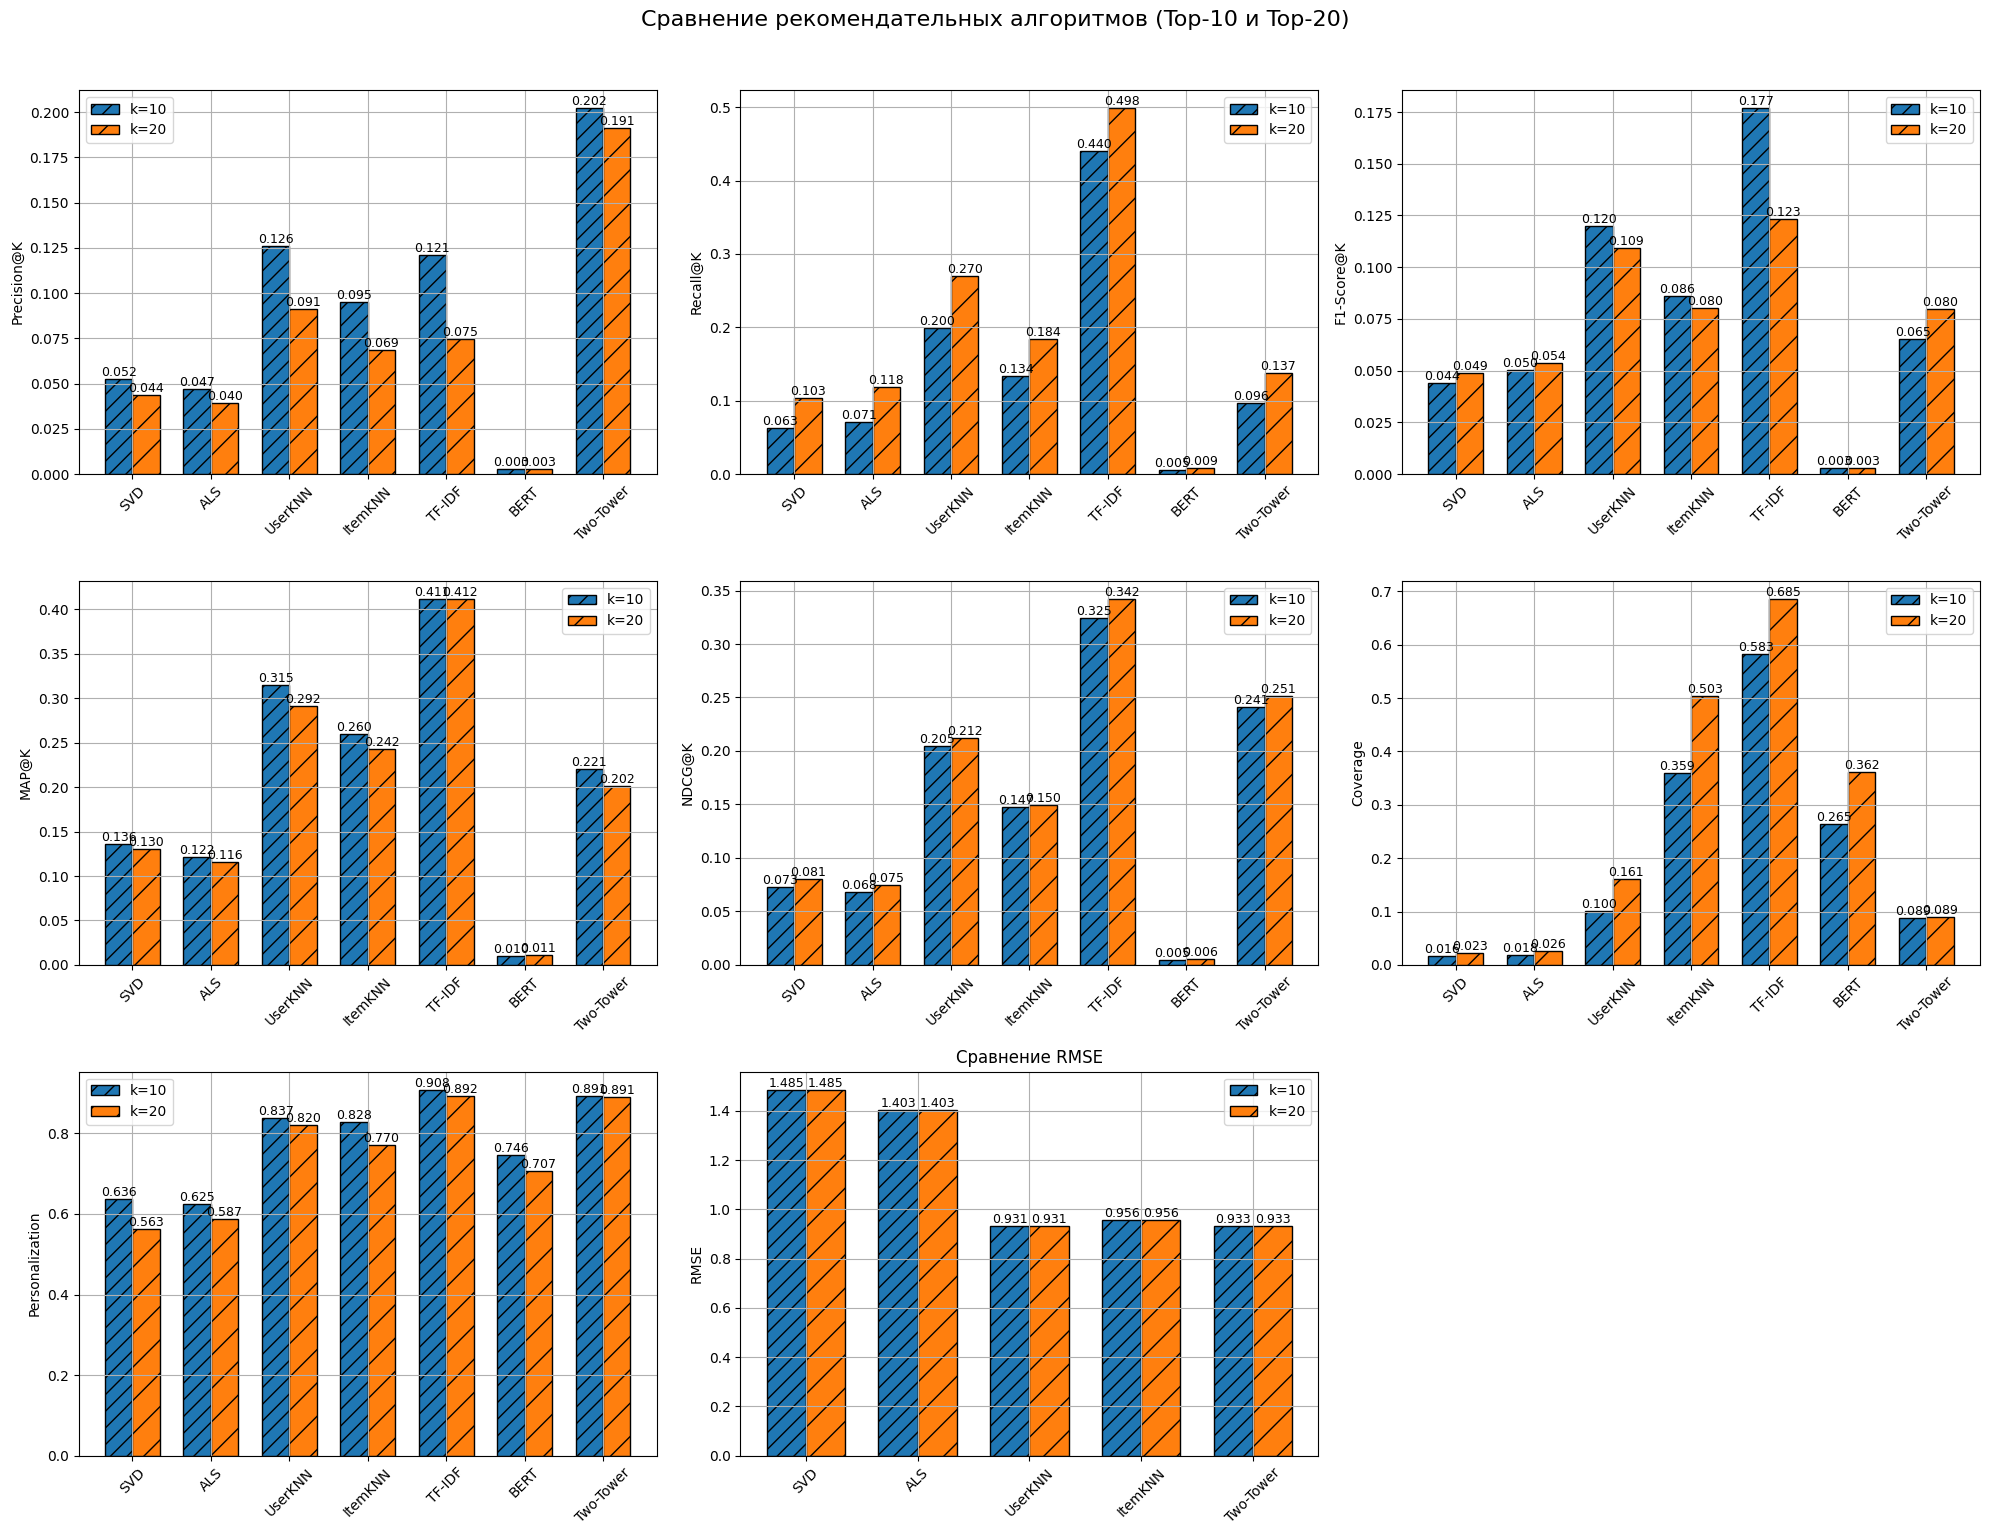

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
metrics = ['Precision', 'Recall', 'F1', 'MAP', 'NDCG', 'Coverage', 'Personalization']
models = ["SVD", "ALS", "UserKNN", "ItemKNN", "TF-IDF", "BERT", "Two-Tower"]

# Создаем фигуру с субплогами
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Сравнение рекомендательных алгоритмов (Top-10 и Top-20)', fontsize=16, y=1.02)

# Удаляем последний пустой субплот
fig.delaxes(axes[2,2])

# Цветовая схема
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Функция для построения группированных столбцов
def plot_grouped_bars(ax, metric, ylabel):
    n = len(models)
    width = 0.35
    x = np.arange(n)
    if metric in metrics[:5]:
        top10 = [results_at_10[model].get(f'{metric}@10', 0) for model in models]
        top20 = [results_at_20[model].get(f'{metric}@20', 0) for model in models]
    else:
        top10 = [results_at_10[model].get(f'{metric}', 0) for model in models]
        top20 = [results_at_20[model].get(f'{metric}', 0) for model in models]

    bars1 = ax.bar(x - width/2, top10, width, label='k=10', edgecolor='black', hatch='//')
    bars2 = ax.bar(x + width/2, top20, width, label='k=20', edgecolor='black', hatch='/')

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()

    # Добавляем значения на столбцы
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Построение графиков для каждой метрики
plot_grouped_bars(axes[0,0], 'Precision', 'Precision@K')
plot_grouped_bars(axes[0,1], 'Recall', 'Recall@K')
plot_grouped_bars(axes[0,2], 'F1', 'F1-Score@K')
plot_grouped_bars(axes[1,0], 'MAP', 'MAP@K')
plot_grouped_bars(axes[1,1], 'NDCG', 'NDCG@K')
plot_grouped_bars(axes[1,2], 'Coverage', 'Coverage')
plot_grouped_bars(axes[2,0], 'Personalization', 'Personalization')

# График для RMSE (особый случай)
ax_rmse = axes[2,1]
rmse_values_10 = [results_at_10[model].get('RMSE', 0) for model in models if 'RMSE' in results_at_10[model]]
rmse_values_20 = [results_at_20[model].get('RMSE', 0) for model in models if 'RMSE' in results_at_20[model]]
rmse_models = [model for model in models if 'RMSE' in results_at_10[model]]

n = len(rmse_models)
width = 0.35
x = np.arange(n)

bars1 = ax_rmse.bar(x - width/2, rmse_values_10, width, label='k=10', edgecolor='black', hatch='//')
bars2 = ax_rmse.bar(x + width/2, rmse_values_20, width, label='k=20', edgecolor='black', hatch='/')

ax_rmse.set_xticks(x)
ax_rmse.set_xticklabels(rmse_models, rotation=45)
ax_rmse.set_ylabel('RMSE')
ax_rmse.set_title(f'Сравнение RMSE')
ax_rmse.grid(True)
ax_rmse.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax_rmse.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

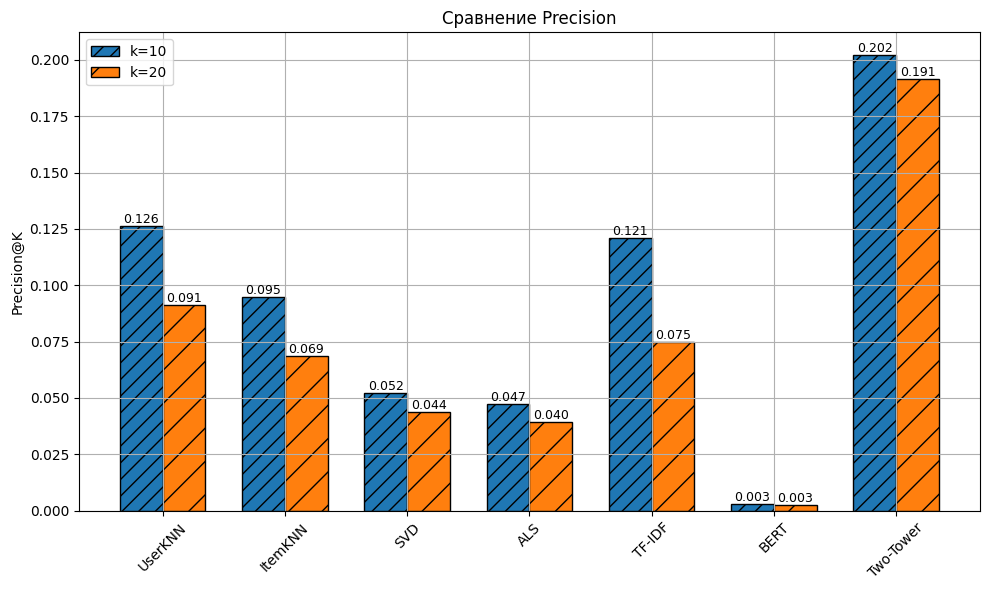

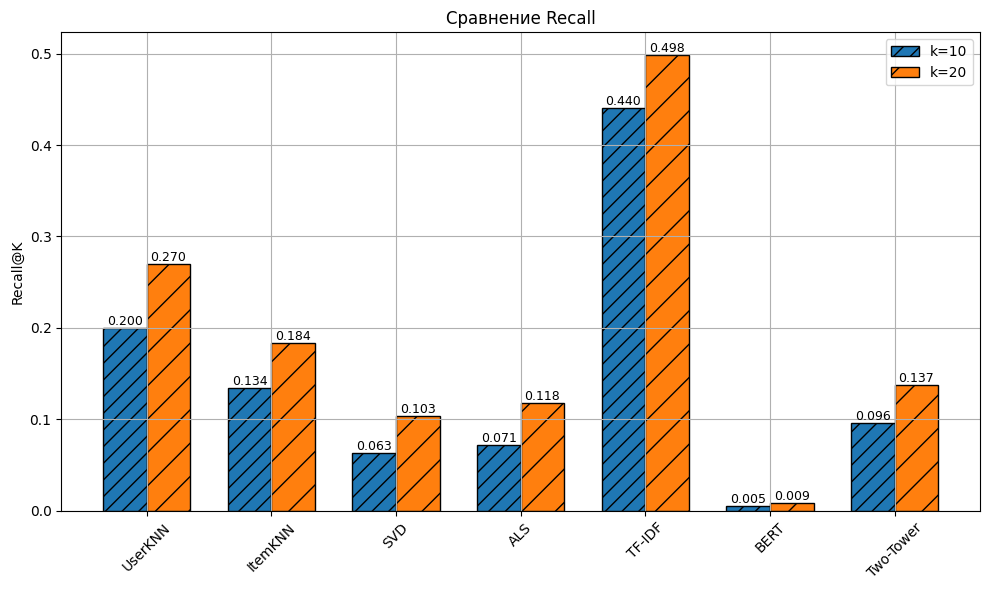

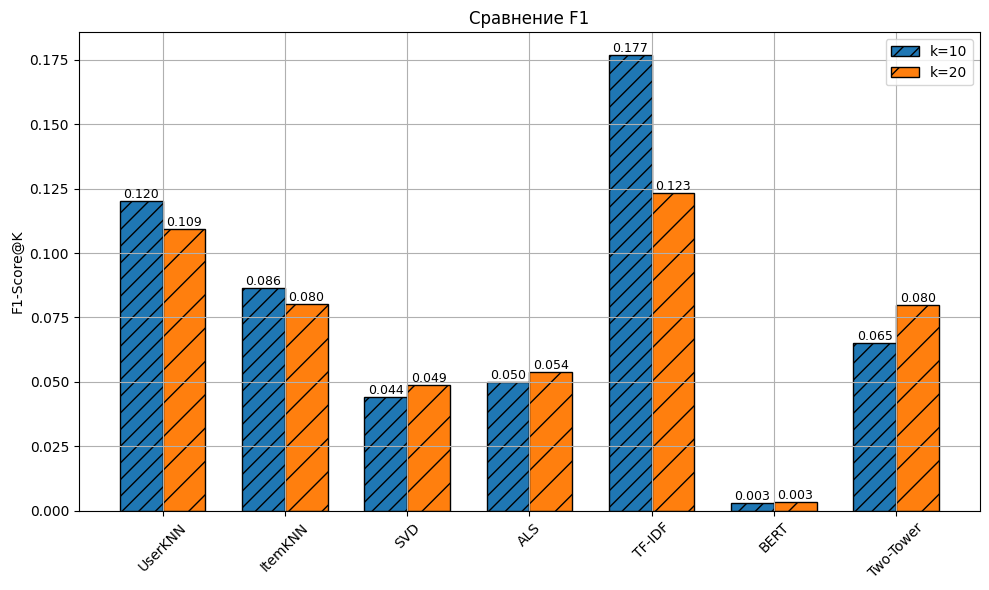

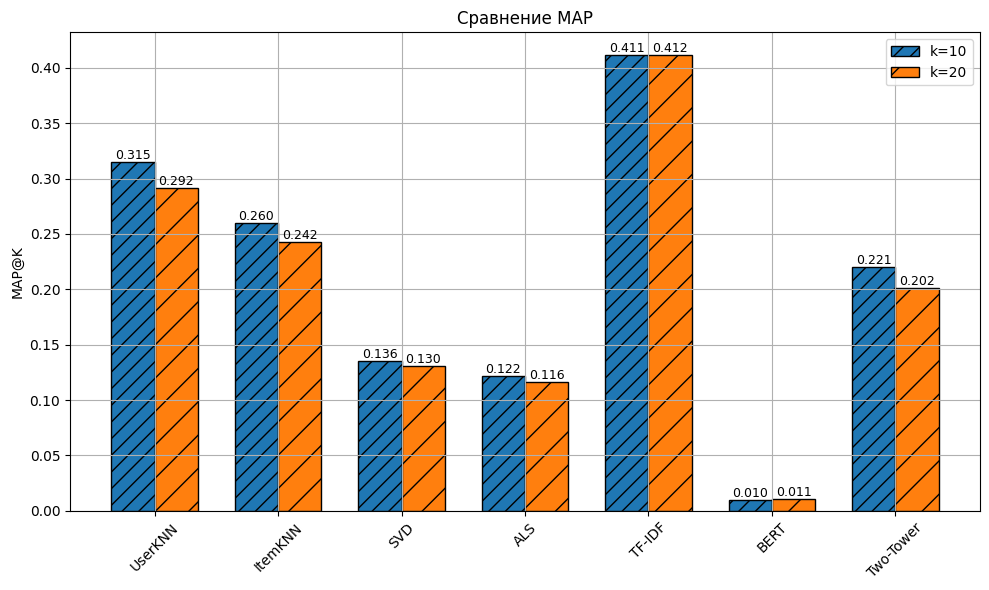

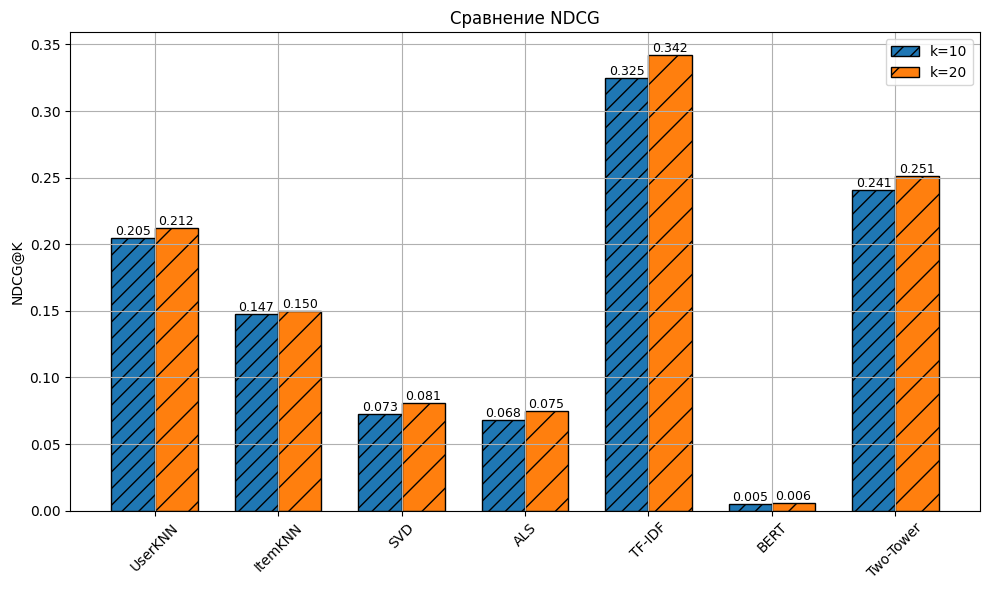

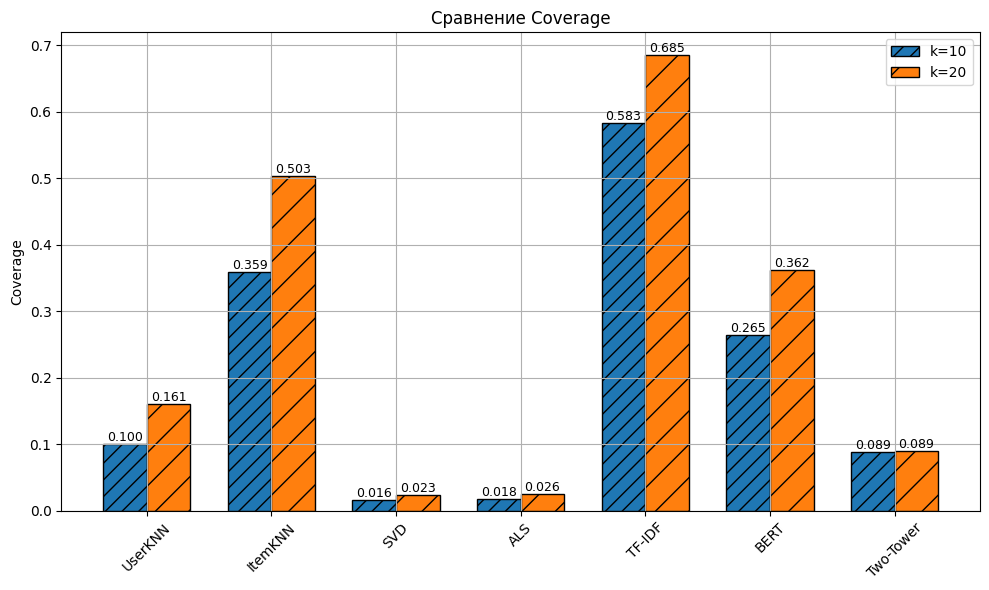

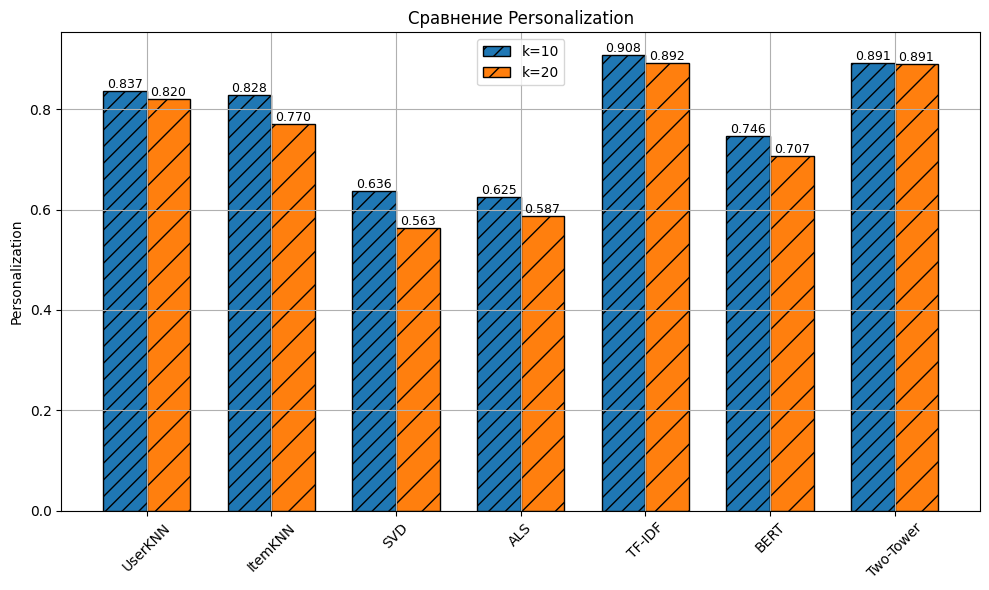

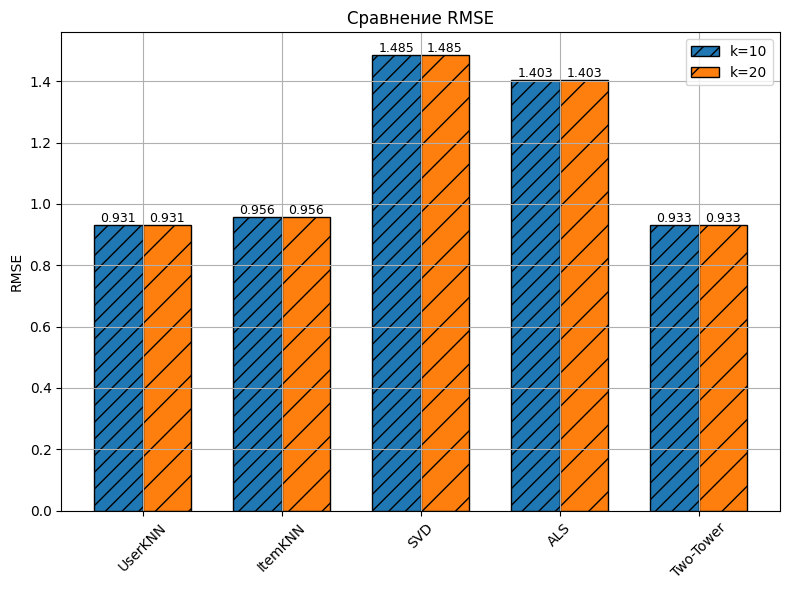

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Метрики и модели
metrics = ['Precision', 'Recall', 'F1', 'MAP', 'NDCG', 'Coverage', 'Personalization', 'RMSE']
models = ["UserKNN", "ItemKNN", "SVD", "ALS", "TF-IDF", "BERT", "Two-Tower"]


# Функция для построения одного графика
def plot_single_metric(metric, ylabel):
    n = len(models)
    width = 0.35
    x = np.arange(n)

    if metric in ['Precision', 'Recall', 'F1', 'MAP', 'NDCG']:
        top10 = [results_at_10[model].get(f'{metric}@10', 0) for model in models]
        top20 = [results_at_20[model].get(f'{metric}@20', 0) for model in models]
    else:
        top10 = [results_at_10[model].get(metric, 0) for model in models]
        top20 = [results_at_20[model].get(metric, 0) for model in models]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, top10, width, label='k=10', edgecolor='black', hatch='//')
    bars2 = ax.bar(x + width/2, top20, width, label='k=20', edgecolor='black', hatch='/')

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(f'Сравнение {metric}')
    ax.grid(True)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Построение графиков по всем метрикам
plot_single_metric('Precision', 'Precision@K')
plot_single_metric('Recall', 'Recall@K')
plot_single_metric('F1', 'F1-Score@K')
plot_single_metric('MAP', 'MAP@K')
plot_single_metric('NDCG', 'NDCG@K')
plot_single_metric('Coverage', 'Coverage')
plot_single_metric('Personalization', 'Personalization')

# Отдельно: график RMSE
def plot_rmse():
    rmse_values_10 = [results_at_10[model].get('RMSE', 0) for model in models if 'RMSE' in results_at_10[model]]
    rmse_values_20 = [results_at_20[model].get('RMSE', 0) for model in models if 'RMSE' in results_at_20[model]]
    rmse_models = [model for model in models if 'RMSE' in results_at_10[model]]
    n = len(rmse_models)
    width = 0.35
    x = np.arange(n)
    fig, ax = plt.subplots(figsize=(8, 6))
    bars1 = ax.bar(x - width/2, rmse_values_10, width, label='k=10', edgecolor='black', hatch='//')
    bars2 = ax.bar(x + width/2, rmse_values_20, width, label='k=20', edgecolor='black', hatch='/')

    ax.set_xticks(x)
    ax.set_xticklabels(rmse_models, rotation=45)
    ax.set_ylabel('RMSE')
    ax.set_title(f'Сравнение RMSE')
    ax.grid(True)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_rmse()


# **New Section**

# Two-Tower Model

In [ ]:
# user_dim, item_dim - n features для представления пользователя/объекта
# embedding_dim - размер эмбеддинга пользователя/айтема
# dropout
# hidden_dim - размер скрытого слоя
class UserEmbeddings(nn.Module):
    """Векторное представление пользователей"""
    def __init__(self, user_dim, embedding_dim, dropouts=[0.3, 0.2], hidden_dims=[128, 64]):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)

        # User tower
        layers = []
        in_dim = user_dim
        for h_dim, dropout in zip(hidden_dims, dropouts):
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.LayerNorm(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, embedding_dim))
        self.user = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x) -> torch.Tensor:
        # x: torch.Tensor (Batch_size, user_dim)
        return self.user(x) # (Batch_size, emb_dim)

class ItemEmbeddings(nn.Module):
    """Векторное представление фильмов"""
    def __init__(self, item_dim, embedding_dim, dropouts=[0.3, 0.2], hidden_dims=[128, 64]):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)

        # Item tower
        layers = []
        in_dim = item_dim
        for h_dim, dropout in zip(hidden_dims, dropouts):
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.LayerNorm(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, embedding_dim))
        self.item = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x) -> torch.Tensor:
        # x: torch.Tensor (Batch_size, item_dim)
        return self.item(x)   # (Batch_size, emb_dim)

class ConcatEmbeddings(nn.Module):
    def __init__(self, emb_dim, dropout=0.2, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        in_dim = emb_dim * 2
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.ReLU(),
                nn.LayerNorm(h_dim),
                nn.Dropout(dropout),
            ])
            in_dim = h_dim
        self.seq = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, user_emb, item_emb):
        x = torch.cat([user_emb, item_emb], dim=1)
        return self.seq(x)

class RecModel(nn.Module):
    def __init__(self, user_dim, item_dim, embedding_dim=256, dropout=0.2, hidden_dims=[128, 64]):
        super().__init__()
        # Многослойный персептрон для эмбеддингов пользователей
        self.user_block = UserEmbeddings(user_dim, embedding_dim, dropouts=[dropout]*len(hidden_dims), hidden_dims=hidden_dims)
        # Многослойный персептрон для эмбеддингов объектов
        self.item_block = ItemEmbeddings(item_dim, embedding_dim, dropouts=[dropout]*len(hidden_dims), hidden_dims=hidden_dims)
        # Объединение (ConcatEmbeddings)
        self.concat = ConcatEmbeddings(embedding_dim, dropout=dropout, hidden_dims=hidden_dims)

    def forward(self, user_feats, item_feats):
        user_emb = self.user_block(user_feats)   # (Batch_size, emb_dim)
        item_emb = self.item_block(item_feats)   # (Batch_size, emb_dim)
        x = self.concat(user_emb, item_emb)   # (Batch_size, emb_dim * 2)
        return user_emb, item_emb, x

class RecHead(nn.Module):
    def __init__(self, input_dim, mode='regression'):
        super().__init__()
        self.mode = mode
        self.head = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, 1)
        )
        self.activation = nn.Sigmoid() if mode == 'classification' else nn.Identity()

    def forward(self, x):
        return self.activation(self.head(x))

class RecModelLightning(pl.LightningModule):
    def __init__(
        self,
        user_dim: int,
        item_dim: int,
        embedding_dim: int,
        dropout: float,
        hidden_dims: list[int],
        lr: float,
        weight_decay: float,
        cos_param: float = 0.1,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.lr = lr
        self.weight_decay = weight_decay

        self.model = RecModel(
            user_dim=user_dim,
            item_dim=item_dim,
            embedding_dim=embedding_dim,
            dropout=dropout,
            hidden_dims=hidden_dims,
        )
        # concat_dim = 2 * embedding_dim
        self.output = RecHead(embedding_dim * 2, mode='regression')
        self.output_loss = nn.MSELoss()
        # self.output_loss = nn.BCEWithLogitsLoss()
        self.vec_cos = nn.CosineSimilarity(dim=1, eps=1e-8)

    def forward(self, user, items):
        """Предсказывание рейтинга
        ---
        user: (batch_size, user_dim)
        items: (batch_size, item_dim)
        ---
        Кортеж тензоров:
        - (batch_size, embedding_dim): Эмбеддинги пользователя
        - (batch_size, embedding_dim): Эмбеддинги объекта
        - (batch_size, 1): Предсказанные рейтинги
        """
        user_emb, item_emb, j = self.model(user, items)  # self.model — основная часть с эмбеддингами и взаимодействиями

        pred = self.output(j)  # self.output — линейный слой или другая голова, возвращающая скаляр

        return user_emb, item_emb, pred

    def training_step(self, batch, batch_idx):
        user, items, labels = [x.to(self.device) for x in batch]
        labels = (labels.float().squeeze() - 0.5) / 4.5

        u, i, x = self.model(user, items)
        preds = self.output(x).flatten()

        reg_loss = self.output_loss(preds, labels)
        vec_loss = 1 - self.vec_cos(u, i).mean()
        loss = reg_loss + self.hparams.cos_param * vec_loss

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_reg_loss', reg_loss, prog_bar=True)
        self.log('train_vec_loss', vec_loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        user, items, labels = [x.to(self.device) for x in batch]
        labels = (labels.float().squeeze() - 0.5) / 4.5

        u, i, x = self.model(user, items)
        preds = self.output(x).flatten()

        val_loss = self.output_loss(preds, labels)
        vec_loss = 1 - self.vec_cos(u, i).mean()

        rmse = torch.sqrt(val_loss)

        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_rmse', rmse, prog_bar=True)
        self.log('val_vec_loss', vec_loss, prog_bar=True)

        return val_loss

    def test_step(self, batch, batch_idx):
        user, items, labels = [x.to(self.device) for x in batch]
        labels = (labels.float().squeeze() - 0.5) / 4.5

        u, i, x = self.model(user, items)
        preds = self.output(x).flatten()

        test_loss = self.output_loss(preds, labels)
        rmse = torch.sqrt(test_loss)

        self.log('test_loss', test_loss, prog_bar=True)
        self.log('test_rmse', rmse, prog_bar=True)
        return test_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

    @torch.no_grad()
    def recommend_items(
        self,
        users: Sequence[int],
        user_seen: Sequence[set[int]],
        top_n: int,
    ):
        item_feats = self.item_features_tensor.to(self.device)  # (M, item_dim)
        item_emb = self.model.item_block(item_feats)            # (M, E)

        user_idxs = [self.all_user_ids.index(u) for u in users]
        user_feats = self.user_features_tensor[user_idxs].to(self.device)  # (U, user_dim)
        user_emb = self.model.user_block(user_feats)                       # (U, E)

        scores = user_emb @ item_emb.T  # (U, M)

        if any(user_seen):
            seen_mask = torch.zeros_like(scores, dtype=torch.bool)
            for i, seen in enumerate(user_seen):
                if seen:
                    seen_indices = [self.all_item_ids.index(m) for m in seen if m in self.all_item_ids]
                    seen_mask[i, seen_indices] = True
            scores = scores.masked_fill(seen_mask, float('-inf'))

        _, topk_indices = torch.topk(scores, k=top_n, dim=1)  # (U, top_n)

        all_item_ids = self.all_item_ids
        recommendations = [
            [all_item_ids[idx] for idx in user_topk]
            for user_topk in topk_indices.cpu().tolist()
        ]
        return recommendations

    @torch.no_grad()
    def recommend_items_bulk(
        self,
        users: Sequence[int],
        user_seen: Sequence[set[int]],
        top_n: int,
    ):
        item_feats = self.item_features_tensor.to(self.device)  # (M, item_dim)
        item_emb = self.model.item_block(item_feats)            # (M, E)

        user_idxs = [self.all_user_ids.index(u) for u in users]
        user_feats = self.user_features_tensor[user_idxs].to(self.device)  # (U, user_dim)
        user_emb = self.model.user_block(user_feats)                       # (U, E)

        scores = user_emb @ item_emb.T  # (U, M)

        if any(user_seen):
            seen_mask = torch.zeros_like(scores, dtype=torch.bool)
            for i, seen in enumerate(user_seen):
                if seen:
                    seen_indices = [self.all_item_ids.index(m) for m in seen if m in self.all_item_ids]
                    seen_mask[i, seen_indices] = True
            scores = scores.masked_fill(seen_mask, float('-inf'))

        _, topk_indices = torch.topk(scores, k=top_n, dim=1)  # (U, top_n)

        all_item_ids = self.all_item_ids
        recommendations = [
            [all_item_ids[idx] for idx in user_topk]
            for user_topk in topk_indices.cpu().tolist()
        ]
        return recommendations

    @torch.no_grad()
    def predict(self, user_id, item_ids):
        uidx = self.all_user_ids.index(user_id)
        iidx = [self.all_item_ids.index(i) for i in item_ids]

        uf = self.user_features_tensor[uidx].to(self.device)   # (N, user_dim)
        itf = self.item_features_tensor[iidx].to(self.device)  # (N, item_dim)

        u_emb, i_emb, x = self.model(uf, itf)                  # (N, E), (N, E), (N, head)
        preds = self.output(x).flatten().cpu().numpy()

        return preds * 4.5 + 0.5


    @torch.no_grad()
    def predict_bulk(self, user_ids, item_ids):
        uidx = [self.all_user_ids.index(u) for u in user_ids]
        iidx = [self.all_item_ids.index(i) for i in item_ids]

        uf = self.user_features_tensor[uidx].to(self.device)   # (N, user_dim)
        itf = self.item_features_tensor[iidx].to(self.device)  # (N, item_dim)

        u_emb, i_emb, x = self.model(uf, itf)                  # (N, E), (N, E), (N, head)
        preds = self.output(x).flatten().cpu().numpy()

        return preds * 4.5 + 0.5

# MovieLensDataset

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        user_encoder: LabelEncoder,
        item_encoder: LabelEncoder,
        user_feats_matrix: np.ndarray,
        item_feats_matrix: np.ndarray
    ):
        self.df = df.reset_index(drop=True)
        self.user_idxs = user_encoder.transform(self.df['userId'])
        self.item_idxs = item_encoder.transform(self.df['movieId'])
        self.ratings = self.df['rating'].values.astype(np.float32)

        self.user_feats_matrix = user_feats_matrix
        self.item_feats_matrix = item_feats_matrix

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        uidx = self.user_idxs[idx]
        iidx = self.item_idxs[idx]
        return (
            torch.from_numpy(self.user_feats_matrix[uidx]),
            torch.from_numpy(self.item_feats_matrix[iidx]),
            torch.tensor([self.ratings[idx]])
        )

    @property
    def user_shape(self):
        return self.user_feats_matrix.shape[1]

    @property
    def item_shape(self):
        return self.item_feats_matrix.shape[1]

# Two-Tower

In [ ]:
embedding_dim = 64
concat_dim = 128
dropout = 0.3
hidden_dims = [64, 32]
lr = 1e-3
weight_decay = 3e-5
batch_size = 512
num_workers = 8
max_epochs = 20
CHECKPOINT_PATH = '/home/jupyter/datasphere/project'
seed = 42
val_check_interval = 1.0

In [ ]:
# Обучение
print('start')
# Разделение(train/test) по времени
train_df = timed_train_for_val_df
val_df = timed_val_df
test_df = timed_test_df

val_df = val_df[
    val_df["userId"].isin(train_df["userId"]) &
    val_df["movieId"].isin(train_df["movieId"])
]
test_df = test_df[
    test_df["userId"].isin(train_df["userId"]) &
    test_df["movieId"].isin(train_df["movieId"])
]
print('Датафреймы обрезаны до train_df')
user_encoder = LabelEncoder().fit(train_df['userId'])
item_encoder = LabelEncoder().fit(train_df['movieId'])

num_users = len(user_encoder.classes_)
num_items = len(item_encoder.classes_)

user_feats_matrix = np.eye(num_users, dtype=np.float32)
item_feats_matrix = np.eye(num_items, dtype=np.float32)
print('Готовим датасет')
# Делаем датасеты, передавая им уже готовые encoder + identity-матрицы:
train_dataset = MovieLensDataset(
    train_df,
    user_encoder,
    item_encoder,
    user_feats_matrix,
    item_feats_matrix
)
val_dataset = MovieLensDataset(
    val_df,
    user_encoder,
    item_encoder,
    user_feats_matrix,
    item_feats_matrix
)
print('Инициализация модели')
# Инициализация модели
lit = RecModelLightning(
    user_dim=train_dataset.user_shape,
    item_dim=train_dataset.item_shape,
    embedding_dim=embedding_dim,
    dropout=dropout,
    hidden_dims=hidden_dims,
    lr=lr,
    weight_decay=weight_decay,
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=CHECKPOINT_PATH,
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

wandb_logger = WandbLogger(project='recsys', log_model=True, save_dir=CHECKPOINT_PATH)
print('Инициализация DataLoaders')
# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    prefetch_factor=4,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    prefetch_factor=4,
    num_workers=num_workers
)

# Фиксируем seed
torch.manual_seed(seed)
print('Обучение')
# Обучение
trainer = Trainer(
    max_epochs=max_epochs,
    callbacks=[MyProgressBar(), checkpoint_callback, early_stop_callback],
    logger=wandb_logger,
    accelerator='auto',
    precision=16,
    accumulate_grad_batches=1,
    val_check_interval=val_check_interval,
)

trainer.fit(lit, train_loader, val_loader)
print('Сохранение')
# Сохранение лучшей модели
best_ckpt = checkpoint_callback.best_model_path
lit = RecModelLightning.load_from_checkpoint(best_ckpt)
lit.eval()

evaluator = RecommenderEvaluator(
    recommender_system=lit,
    train_df=train_df,
    test_df=test_df,
    k=10,
    rating_threshold=3.5,
    detailed=True
)
all_metrics = evaluator.evaluate()
all_metrics.update(evaluator.evaluate_rmse())
print(all_metrics)

In [ ]:
from torchmetrics.regression import MeanSquaredError

def compute_rmse_from_model(model, user_ids, item_ids, ratings, user_enc, item_enc):
    model.eval()

    user_idxs = user_enc.transform(user_ids)
    item_idxs = item_enc.transform(item_ids)

    user_feats = torch.eye(len(user_enc.classes_))[user_idxs].to(model.device)
    item_feats = torch.eye(len(item_enc.classes_))[item_idxs].to(model.device)
    ratings_tensor = torch.tensor(ratings, dtype=torch.float32).to(model.device)

    with torch.no_grad():
        preds = model(user_feats, item_feats)

    rmse = MeanSquaredError(squared=False).to(model.device)
    return rmse(preds, ratings_tensor).item()

In [ ]:
recsys_tower = RecSysWrapper(
    lit_model=lit,
    train_df=train_df,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

recsys_tower_10_eval = RecommenderEvaluator(recsys_tower, train_df, test_df, k=10)
tower_at_10 = recsys_tower_10_eval.evaluate()
print(tower_at_10)
# rmse_at_10 = recsys_tower_10_eval.evaluate_rmse()
# print(rmse_at_10)
recsys_tower_20_eval = RecommenderEvaluator(recsys_tower, train_df, test_df, k=20)
tower_at_20 = recsys_tower_20_eval.evaluate()
print(tower_at_20)
# rmse_at_20 = recsys_tower_20_eval.evaluate_rmse()
# print(rmse_at_20)